## Code Synopsis

### Data Preprocessing and Exploration

The code begins with importing and cleaning VIX data, including handling missing values and applying various transformations such as log transformation and differencing. These steps are crucial for preparing the data for time series modeling. The code also includes visualization of the data, ACF, and PACF plots, which help in identifying potential seasonality and determining appropriate model parameters.

### Model Development
Several models are developed and compared:
1.	SARIMA (Seasonal AutoRegressive Integrated Moving Average)
2.	SARIMAX (SARIMA with exogenous variables)
3.	SARIMAX-GARCH (SARIMAX combined with Generalized AutoRegressive Conditional Heteroskedasticity)
4.	SARIMAX-COPULA-GARCH (SARIMAX-GARCH with copula for capturing complex dependencies)

Each model builds upon the previous one, aiming to capture different aspects of the VIX time series, including seasonality, external factors, and volatility clustering.

### Model Diagnostics
For each model, extensive diagnostics are performed, including residual analysis, ACF/PACF of residuals, Q-Q plots, and Ljung-Box tests. These diagnostics help in assessing model adequacy and identifying any remaining patterns in the residuals that the model hasn’t captured.

### Model Comparison
The models are compared using several metrics including R-squared, RMSE, MAPE, and Directional Accuracy. The results suggest that the more complex models (SARIMAX-GARCH and SARIMAX-COPULA-GARCH) generally outperform the simpler models, indicating that accounting for volatility clustering and complex dependencies improves forecast accuracy.

### VIX Forecast
The final section presents a 24-month forecast of the VIX using the best-performing model. The forecast includes confidence intervals, providing a range of possible future VIX values. This forecast could be valuable for risk management and investment decision-making in financial markets.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import scipy
import sklearn

## Data Importing & Cleaning

This section imports necessary libraries and loads the VIX data. 

The date column is set as the index and converted to datetime format

In [4]:
data = pd.read_csv('VIX_data_new.csv')

In [5]:
data.head()

,Date,Unemployment Rate,CPI,Fed Rate,BBB Rate,VIX,GDP,JPY/USD Spot Rate,Spot Crude Oil Price,SP500 ^GSPC,...,DJI ^DJI,DJI ^DJI.1,RUSSELL2000 ^RUT,RUSSELL2000 ^RUT.1,FTSE ^FTSE,FTSE ^FTSE.1,NIKKEI ^N225,NIKKEI ^N225.1,GOLD GC=F,USD INDEX DX-Y.NYB
0,2004-12-01,5.4,191.7,2.16,5.04,12.550,12527.214,103.81,43.33,1211.920044,...,10783.009766,5744730000,651.570007,31102700000,4814.299805,28451048500,11488.759766,1437800000,12728,80.849998
1,2005-01-01,5.3,191.6,2.28,5.13,13.340,12767.286,103.34,46.84,1181.270020,...,10489.940430,5424930000,624.020020,31498000000,4852.299805,31489218700,11387.589844,1616200000,115342,83.599998
2,2005-02-01,5.4,192.4,2.50,5.11,11.600,12767.286,104.94,47.97,1203.599976,...,10766.230469,5038600000,634.059998,29297410000,4968.500000,33004713300,11740.599609,1665700000,8468,82.510002
3,2005-03-01,5.2,193.1,2.63,5.50,13.145,12767.286,105.25,54.31,1180.589966,...,10503.759766,5820160000,615.070007,39014150000,4894.399902,34739240300,11668.950195,2032200000,3171,84.059998
4,2005-04-01,5.2,193.7,2.79,5.65,14.530,12922.656,107.19,53.04,1156.849976,...,10192.509766,5852240000,579.380005,43424270000,4801.700195,32554037300,11008.900391,1675000000,2579,84.430000


In [6]:
data.shape

(206, 23)

In [7]:
total_check = data.isnull().sum() + (data== '').sum()
has_missing_data = total_check.sum() >0
print(has_missing_data)

False


In [8]:
data.index = pd.to_datetime(data['Date'])

In [9]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
column_means = data[numeric_columns].mean()

data_filled = data.copy()
data_filled[numeric_columns].fillna(column_means)

,Unemployment Rate,CPI,Fed Rate,BBB Rate,VIX,GDP,JPY/USD Spot Rate,Spot Crude Oil Price,SP500 ^GSPC,SP500 ^GSPC.1,...,DJI ^DJI,DJI ^DJI.1,RUSSELL2000 ^RUT,RUSSELL2000 ^RUT.1,FTSE ^FTSE,FTSE ^FTSE.1,NIKKEI ^N225,NIKKEI ^N225.1,GOLD GC=F,USD INDEX DX-Y.NYB
Date,,,,,,,,,,,,,,,,,,,,,
2004-12-01,5.4,191.700,2.16,5.04,12.550,12527.214,103.81,43.33,1211.920044,31102500000,...,10783.009766,5744730000,651.570007,31102700000,4814.299805,28451048500,11488.759766,1437800000,12728,80.849998
2005-01-01,5.3,191.600,2.28,5.13,13.340,12767.286,103.34,46.84,1181.270020,31498800000,...,10489.940430,5424930000,624.020020,31498000000,4852.299805,31489218700,11387.589844,1616200000,115342,83.599998
2005-02-01,5.4,192.400,2.50,5.11,11.600,12767.286,104.94,47.97,1203.599976,29297410000,...,10766.230469,5038600000,634.059998,29297410000,4968.500000,33004713300,11740.599609,1665700000,8468,82.510002
2005-03-01,5.2,193.100,2.63,5.50,13.145,12767.286,105.25,54.31,1180.589966,39014150000,...,10503.759766,5820160000,615.070007,39014150000,4894.399902,34739240300,11668.950195,2032200000,3171,84.059998
2005-04-01,5.2,193.700,2.79,5.65,14.530,12922.656,107.19,53.04,1156.849976,43424270000,...,10192.509766,5852240000,579.380005,43424270000,4801.700195,32554037300,11008.900391,1675000000,2579,84.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,4.1,313.049,5.33,5.63,12.645,29016.714,157.86,79.77,5460.479980,76025620000,...,39118.859375,7213580000,2047.689941,76025620000,8164.100098,18910547600,39583.078125,2209000000,7958,105.870003
2024-07-01,4.3,313.534,5.33,5.53,13.190,29374.914,157.52,81.80,5522.299805,80160390000,...,40842.789062,7507140000,2254.479980,80160390000,8368.000000,16067728100,39101.820312,2570500000,155434,104.099998
2024-08-01,4.2,314.121,5.33,5.20,16.690,29374.914,146.26,76.68,5648.399902,81097300000,...,41563.078125,8368220000,2217.629883,81097300000,8376.599609,18173603500,38647.750000,3034000000,12103,101.699997


In [10]:
VIX_data = data_filled['VIX']

In [11]:
if isinstance(VIX_data, pd.Series):
    VIX = VIX_data.to_frame(name='VIX')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

## Data Transformations

Here, we apply various transformations to the VIX data:

- Log transformation: $log(VIX + 1)$
- First-order differencing: $\Delta VIX_t = VIX_t - VIX_{t-1}$
- Seasonal differencing (12-month) : $\Delta_{12} VIX_t = VIX_t - VIX_{t-12}$

These transformations help in stabilizing variance and removing trends/seasonality.


In [14]:
#Log Transformation
log_VIX = np.log1p(VIX)

In [15]:
#Differencing
diff_VIX = VIX.diff() #First order differencing
diff_VIX.iloc[0] = 0


diff_log_VIX = log_VIX.diff() 
diff_log_VIX.iloc[0] = 0

In [16]:
# Seasonal Differencing for Monthly Data (12-month seasonality)
seasonal_diff_VIX = VIX.diff(periods=12)
seasonal_diff_log_VIX = log_VIX.diff(periods=12)

In [17]:
#Rolling statistics

def calculate_rolling_stats(df, window):
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    return rolling_mean, rolling_std

window_size = 12

rolling_mean, rolling_std = calculate_rolling_stats(VIX, window=window_size)
rolling_mean_log_data, rolling_std_log_data = calculate_rolling_stats(log_VIX, window=window_size)
rolling_mean_diff_data, rolling_std_diff_data = calculate_rolling_stats(diff_VIX, window=window_size)
rolling_mean_diff_log_data, rolling_std_diff_log_data = calculate_rolling_stats(diff_log_VIX, window=window_size)
rolling_mean_seasonal_diff, rolling_std_seasonal_diff = calculate_rolling_stats(seasonal_diff_VIX, window=window_size)
rolling_mean_seasonal_diff_log_data, rolling_std_seasonal_diff_log_data = calculate_rolling_stats(seasonal_diff_log_VIX, window=window_size)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
#Decompose

def decompose_and_plot(series, period):
    decomposition = seasonal_decompose(series, model='additive', period=period)

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 3)
    
    fig.suptitle('VIX', fontsize=20)
    

    #Plot original data
    ax_original = fig.add_subplot(gs[0, :])
    ax_original.plot(series)
    ax_original.set_title('Original')
    ax_original.set_xlabel('')

    #Plot trend
    ax_trend = fig.add_subplot(gs[1, 0])
    ax_trend.plot(decomposition.trend)
    ax_trend.set_title('Trend')

    #Plot seasonal
    ax_seasonal = fig.add_subplot(gs[1, 1])
    ax_seasonal.plot(decomposition.seasonal)
    ax_seasonal.set_title('Seasonal')

    #Plot residual
    ax_residual = fig.add_subplot(gs[1, 2])
    ax_residual.plot(decomposition.resid)
    ax_residual.set_title('Residual')

    plt.tight_layout()
    plt.show()

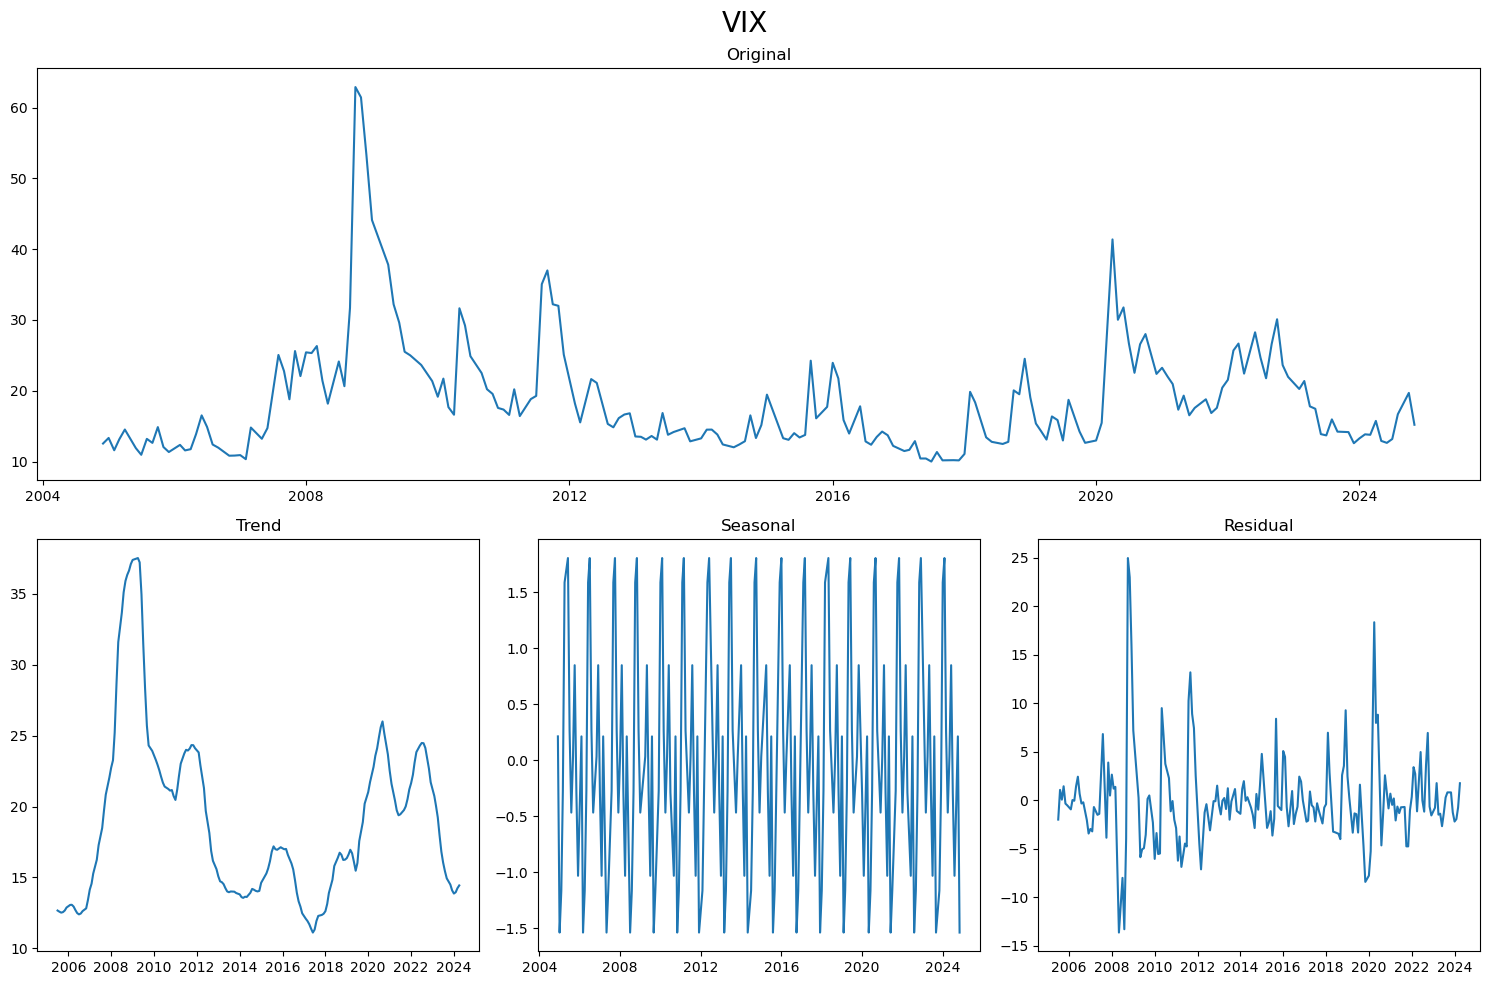

In [20]:
period = 12

decompose_and_plot(VIX, period)

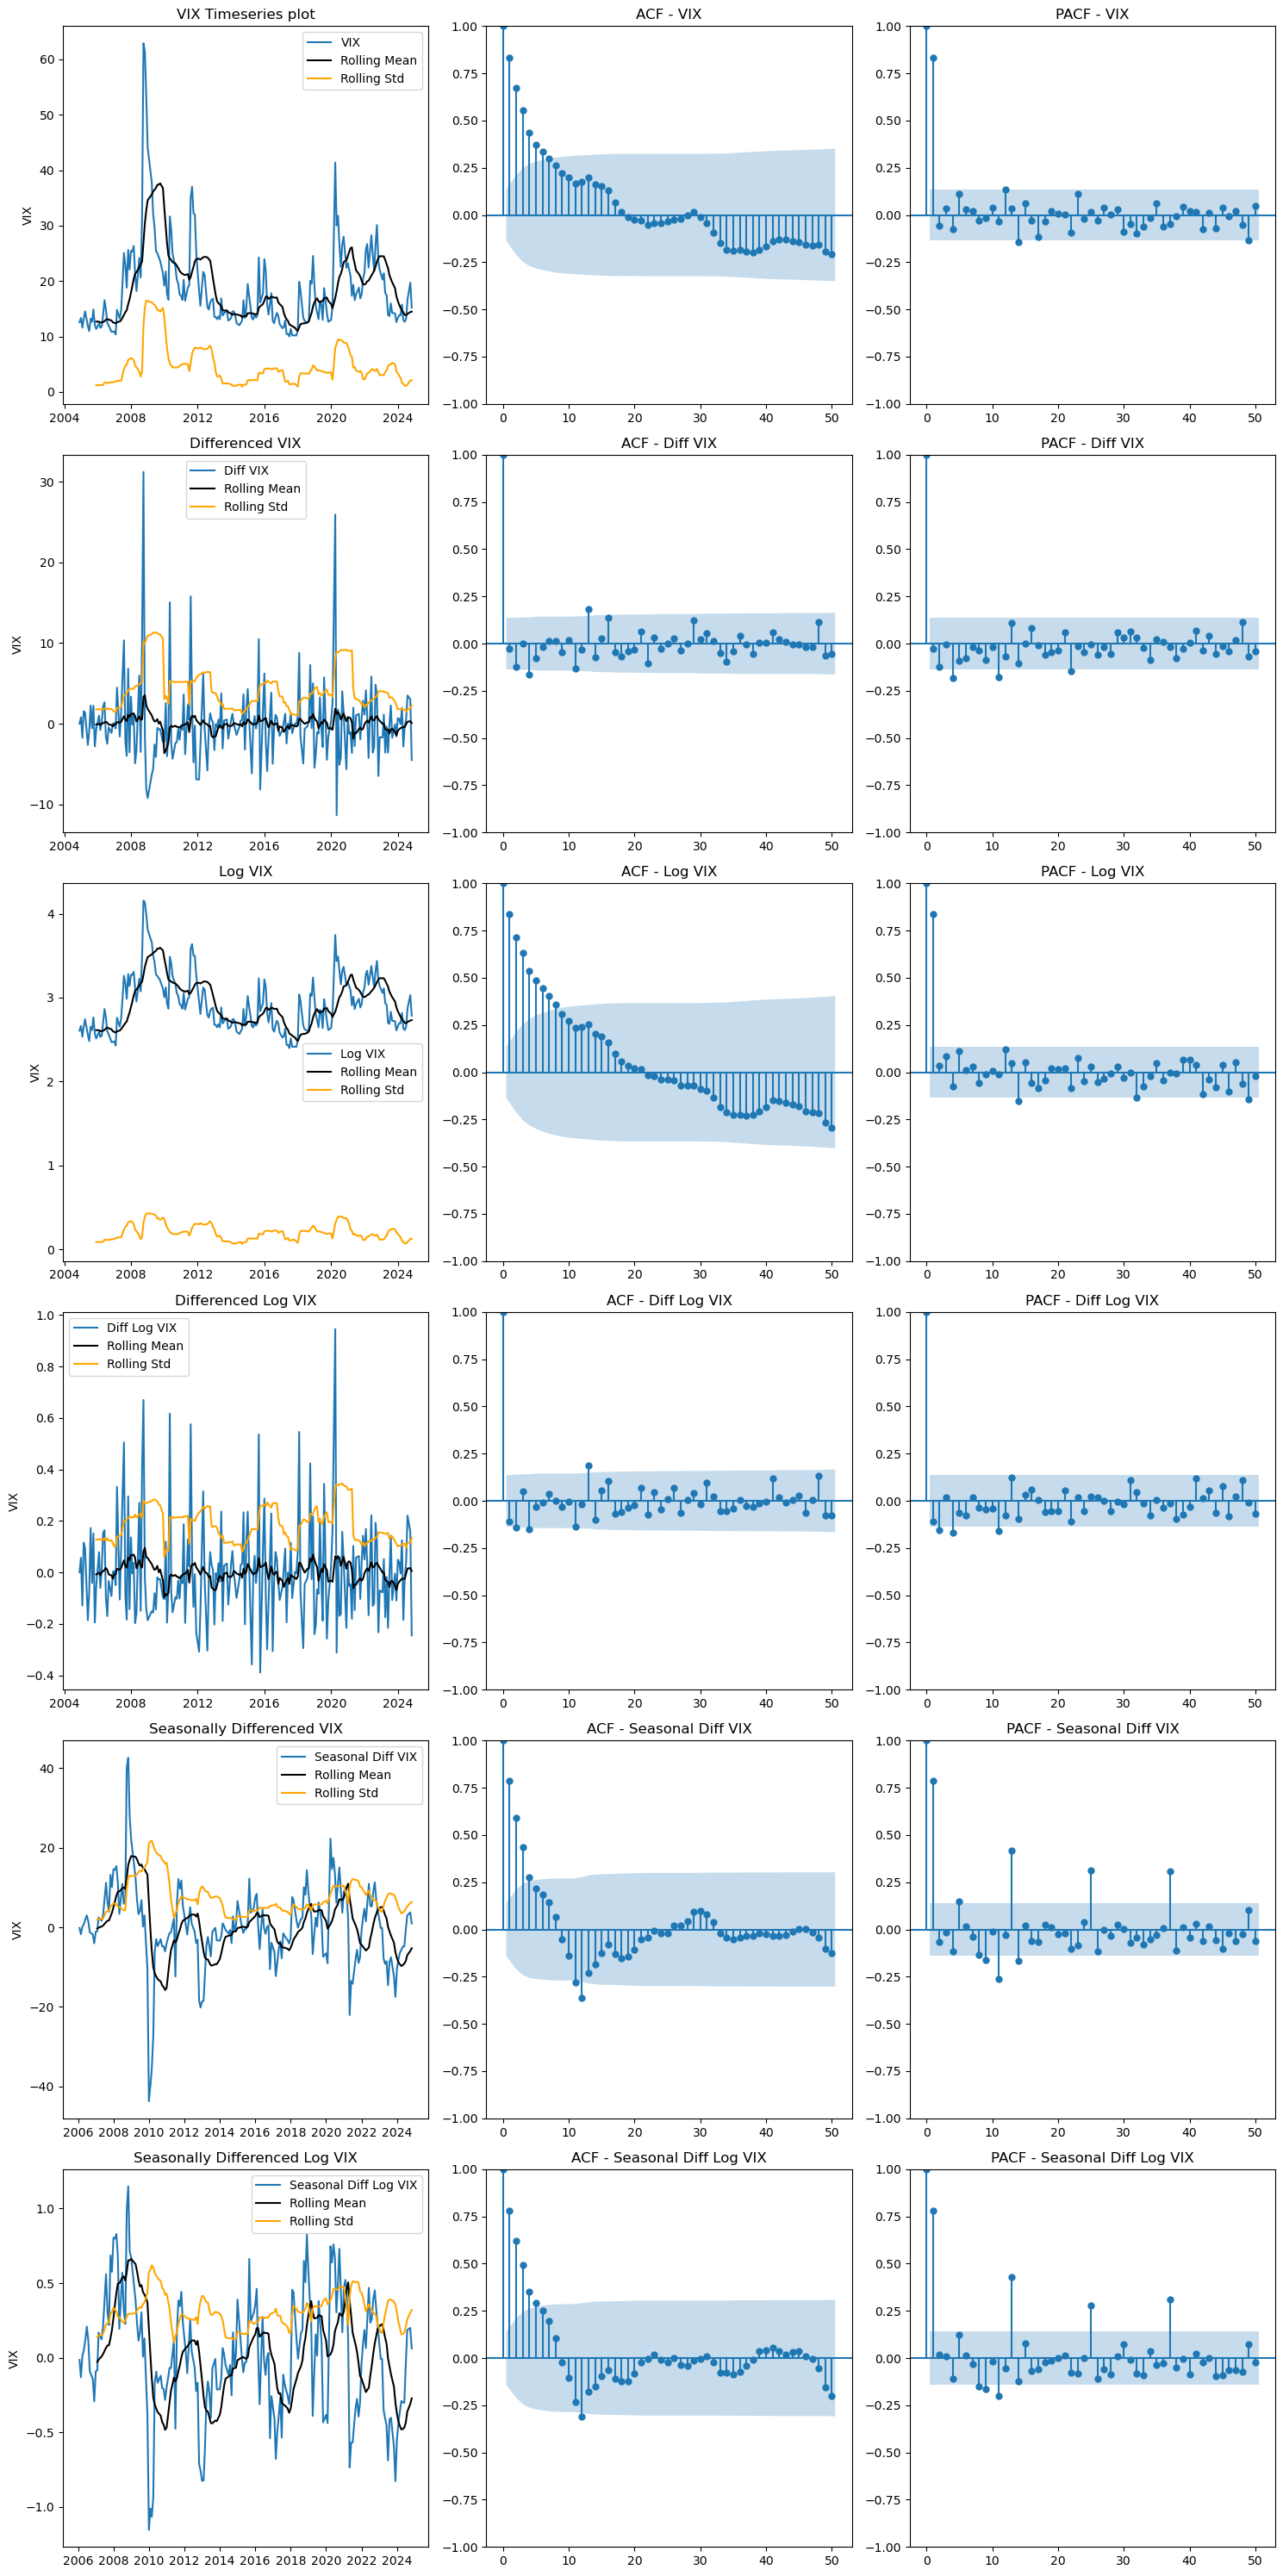

In [21]:
#VIX plots

n_cols = 3
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))


#VIX Data
sns.lineplot(data=VIX, x=VIX.index, y=VIX['VIX'], label='VIX', ax=axes[0,0])
sns.lineplot(data=rolling_mean, x=rolling_mean.index, y=rolling_mean['VIX'], color='black', label='Rolling Mean', ax=axes[0,0])
sns.lineplot(data=rolling_std, x=rolling_std.index, y=rolling_std['VIX'], color='orange', label='Rolling Std', ax=axes[0,0])
axes[0,0].legend(loc='best')
axes[0,0].set_title("VIX Timeseries plot")
axes[0,0].set_xlabel('')

# sns.histplot(data=VIX, x=VIX['VIX'], kde=True, bins='auto', ax=axes[0,1])
# axes[0,1].set_title("Histogram of VIX")

sm.graphics.tsa.plot_acf(VIX['VIX'], lags=50, ax=axes[0,1])
axes[0,1].set_title('ACF - VIX')

sm.graphics.tsa.plot_pacf(VIX['VIX'], lags=50, ax=axes[0,2])
axes[0,2].set_title('PACF - VIX')

#Differencing 1 
sns.lineplot(data=diff_VIX, x=diff_VIX.index, y=diff_VIX['VIX'], label='Diff VIX', ax=axes[1,0])
sns.lineplot(data=rolling_mean_diff_data, x=rolling_mean_diff_data.index, y=rolling_mean_diff_data['VIX'], color='black', label='Rolling Mean', ax=axes[1,0])
sns.lineplot(data=rolling_std_diff_data, x=rolling_std_diff_data.index, y=rolling_std_diff_data['VIX'], color='orange', label='Rolling Std', ax=axes[1,0])
axes[1,0].legend(loc='best')
axes[1,0].set_title("Differenced VIX")
axes[1,0].set_xlabel('')

sm.graphics.tsa.plot_acf(diff_VIX['VIX'], lags=50, ax=axes[1,1])
axes[1,1].set_title('ACF - Diff VIX')

sm.graphics.tsa.plot_pacf(diff_VIX['VIX'], lags=50, ax=axes[1,2])
axes[1,2].set_title('PACF - Diff VIX')

#Log of VIX
sns.lineplot(data=log_VIX, x=VIX.index, y=log_VIX['VIX'], label='Log VIX', ax=axes[2,0])
sns.lineplot(data=rolling_mean_log_data, x=rolling_mean_log_data.index, y=rolling_mean_log_data['VIX'], color='black', label='Rolling Mean', ax=axes[2,0])
sns.lineplot(data=rolling_std_log_data, x=rolling_std_log_data.index, y=rolling_std_log_data['VIX'], color='orange', label='Rolling Std', ax=axes[2,0])
axes[2,0].legend(loc='best')
axes[2,0].set_title("Log VIX")
axes[2,0].set_xlabel('')

sm.graphics.tsa.plot_acf(log_VIX['VIX'], lags=50, ax=axes[2,1])
axes[2,1].set_title('ACF - Log VIX')

sm.graphics.tsa.plot_pacf(log_VIX['VIX'], lags=50, ax=axes[2,2])
axes[2,2].set_title('PACF - Log VIX')

#Difference of Log VIX
sns.lineplot(data=diff_log_VIX, x=diff_log_VIX.index, y=diff_log_VIX['VIX'], label='Diff Log VIX', ax=axes[3,0])
sns.lineplot(data=rolling_mean_diff_log_data, x=rolling_mean_diff_log_data.index, y=rolling_mean_diff_log_data['VIX'], color='black', label='Rolling Mean', ax=axes[3,0])
sns.lineplot(data=rolling_std_diff_log_data, x=rolling_std_diff_log_data.index, y=rolling_std_diff_log_data['VIX'], color='orange', label='Rolling Std', ax=axes[3,0])
axes[3,0].legend(loc='best')
axes[3,0].set_title("Differenced Log VIX")
axes[3,0].set_xlabel('')

sm.graphics.tsa.plot_acf(diff_log_VIX['VIX'], lags=50, ax=axes[3,1])
axes[3,1].set_title('ACF - Diff Log VIX')

sm.graphics.tsa.plot_pacf(diff_log_VIX['VIX'], lags=50, ax=axes[3,2])
axes[3,2].set_title('PACF - Diff Log VIX')


#Seasonal differencing 
sns.lineplot(data=seasonal_diff_VIX, x=seasonal_diff_VIX.index, y=seasonal_diff_VIX['VIX'], label='Seasonal Diff VIX', ax=axes[4,0])
sns.lineplot(data=rolling_mean_seasonal_diff, x=rolling_mean_seasonal_diff.index, y=rolling_mean_seasonal_diff['VIX'], color='black', label='Rolling Mean', ax=axes[4,0])
sns.lineplot(data=rolling_std_seasonal_diff, x=rolling_std_seasonal_diff.index, y=rolling_std_seasonal_diff['VIX'], color='orange', label='Rolling Std', ax=axes[4,0])
axes[4,0].legend(loc='best')
axes[4,0].set_title("Seasonally Differenced VIX")
axes[4,0].set_xlabel('')

sm.graphics.tsa.plot_acf(seasonal_diff_VIX['VIX'].dropna(), lags=50, ax=axes[4,1])
axes[4,1].set_title('ACF - Seasonal Diff VIX')

sm.graphics.tsa.plot_pacf(seasonal_diff_VIX['VIX'].dropna(), lags=50, ax=axes[4,2])
axes[4,2].set_title('PACF - Seasonal Diff VIX')

#Seasonal differencing Log VIX
sns.lineplot(data=seasonal_diff_log_VIX, x=seasonal_diff_log_VIX.index, y=seasonal_diff_log_VIX['VIX'], label='Seasonal Diff Log VIX', ax=axes[5,0])
sns.lineplot(data=rolling_mean_seasonal_diff_log_data, x=rolling_mean_seasonal_diff_log_data.index, y=rolling_mean_seasonal_diff_log_data['VIX'], color='black', label='Rolling Mean', ax=axes[5,0])
sns.lineplot(data=rolling_std_seasonal_diff_log_data, x=rolling_std_seasonal_diff_log_data.index, y=rolling_std_seasonal_diff_log_data['VIX'], color='orange', label='Rolling Std', ax=axes[5,0])
axes[5,0].legend(loc='best')
axes[5,0].set_title("Seasonally Differenced Log VIX")
axes[5,0].set_xlabel('')

sm.graphics.tsa.plot_acf(seasonal_diff_log_VIX['VIX'].dropna(), lags=50, ax=axes[5,1])
axes[5,1].set_title('ACF - Seasonal Diff Log VIX')

sm.graphics.tsa.plot_pacf(seasonal_diff_log_VIX['VIX'].dropna(), lags=50, ax=axes[5,2])
axes[5,2].set_title('PACF - Seasonal Diff Log VIX')

plt.tight_layout()
plt.show()

## Time Series Models 

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [23]:
import warnings

In [24]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Define the range of p, d, q, P, D, Q values to test
p_values = range(1, 3)
d_values = range(1, 2)
q_values = range(1, 3)
P_values = range(1, 2)
D_values = range(1, 2)
Q_values = range(1, 2)
m_values = [12]  #Monthly seasonality

# Initialize list to store results
results = []

# Iterate through different combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            try:
                                # Fit SARIMA model
                                model = SARIMAX(VIX, order=(p, d, q), seasonal_order=(P, D, Q, m))
                                results_sarima = model.fit(disp=False)
                                
                                # Calculate AIC
                                aic = results_sarima.aic
                                
                                # Calculate SSE
                                sse = np.sum(results_sarima.resid**2)
                                
                                # Perform Ljung-Box test
                                lb_test = acorr_ljungbox(results_sarima.resid, lags=[10], return_df=True)
                                lb_pvalue = lb_test['lb_pvalue'].values[0]
                                
                                # Store results
                                results.append({
                                    'p': p, 'd': d, 'q': q,
                                    'P': P, 'D': D, 'Q': Q, 'm': m,
                                    'AIC': aic,
                                    'SSE': sse,
                                    'LjungBox_pval': lb_pvalue
                                })
                            except:
                                # If the model fails to converge, skip this combination
                                continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter results for significant p-values (e.g., p-value < 0.05) and low AIC
significant_results = results_df[(results_df['LjungBox_pval'] > 0.05) & (results_df['AIC'].notnull())]

# Sort by AIC to find the best model
best_model = significant_results.sort_values(by='AIC').iloc[0] if not significant_results.empty else None

print("All results:")
print(results_df)
print("\nBest model:")
print(best_model)


All results:
   p  d  q  P  D  Q   m          AIC          SSE  LjungBox_pval
0  1  1  1  1  1  1  12  1176.163850  4975.178360       0.612846
1  1  1  2  1  1  1  12  1177.151595  4933.443854       0.769408
2  2  1  1  1  1  1  12  1184.494892  5110.502938       0.420164
3  2  1  2  1  1  1  12  1177.985202  4906.266451       0.898145

Best model:
p                   1.000000
d                   1.000000
q                   1.000000
P                   1.000000
D                   1.000000
Q                   1.000000
m                  12.000000
AIC              1176.163850
SSE              4975.178360
LjungBox_pval       0.612846
Name: 0, dtype: float64


In [25]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

In [26]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

In [27]:
def mean_directional_accuracy(actual, predicted):
    actual = np.asarray(actual).flatten()
    predicted = np.asarray(predicted).flatten()

    if len(actual) != len(predicted):
        raise ValueError("Input arrays must have the same length")

    if len(actual) < 2:
        raise ValueError("Input arrays must have at least two elements")

    actual_diff = np.diff(actual)
    predicted_diff = np.diff(predicted)

    # Handle cases where there are no changes in actual values
    valid_indices = actual_diff != 0
    if np.sum(valid_indices) == 0:
        return np.nan  # or another appropriate value

    num_correct = np.sum((np.sign(actual_diff[valid_indices]) == np.sign(predicted_diff[valid_indices])))
    mda = num_correct / np.sum(valid_indices)

    return mda

## SARIMA model

The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model is defined as:
$$(1 -\phi_1 B - \phi_2 B^2) (1 - \Phi_1 B^{12} - \Phi_2 B^{24})(1 - B)(1 - B^{12}) y_t = (1 + \theta_1 B + \theta_2 B^2) (1 + \Theta_1 B^{12} + \Theta_2 B^{24}) \epsilon_t$$

where:
- B is the backshift operator
- $\phi_i , \Phi_i$ are the AR and seasonal AR parameters
- $\theta_i, \Theta_i$ are the MA and seasonal MA parameters 

The SARIMA model combines several components to capture different aspects of time series data:

1. Autoregressive (AR) component: $(1 - \phi_1B - \phi_2B^2)$ models the relationship between an observation and a certain number of lagged observations.

2. Integrated (I) component: $(1-B)(1-B^{12})$ represents differencing of the time series to make it stationary. The $(1-B)$ term is for regular differencing, while $(1-B^{12})$ is for seasonal differencing (assuming monthly data).

3. Moving Average (MA) component: $(1 + \theta_1B + \theta_2B^2)$ models the relationship between an observation and a residual error from a moving average model applied to lagged observations.

4. Seasonal components: $(1 - \Phi_1B^{12} - \Phi_2B^{24})$ and $(1 + \Theta_1B^{12} + \Theta_2B^{24})$ capture seasonal patterns in the data, typically with a period of 12 for monthly data.

The SARIMA model is particularly useful for time series data that exhibit both trend and seasonal patterns. It allows for flexible modeling of complex temporal structures and can capture a wide range of time series behaviors.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87621D+00    |proj g|=  9.39008D-02

At iterate    5    f=  2.76973D+00    |proj g|=  5.29266D-02


 This problem is unconstrained.



At iterate   10    f=  2.76263D+00    |proj g|=  6.04939D-03

At iterate   15    f=  2.76072D+00    |proj g|=  7.90271D-03

At iterate   20    f=  2.76038D+00    |proj g|=  7.28129D-04

At iterate   25    f=  2.76021D+00    |proj g|=  5.74336D-04

At iterate   30    f=  2.76020D+00    |proj g|=  3.61985D-04

At iterate   35    f=  2.76020D+00    |proj g|=  1.69672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     39      1     0     0   1.310D-05   2.760D+00
  F =   2.7601962030690008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


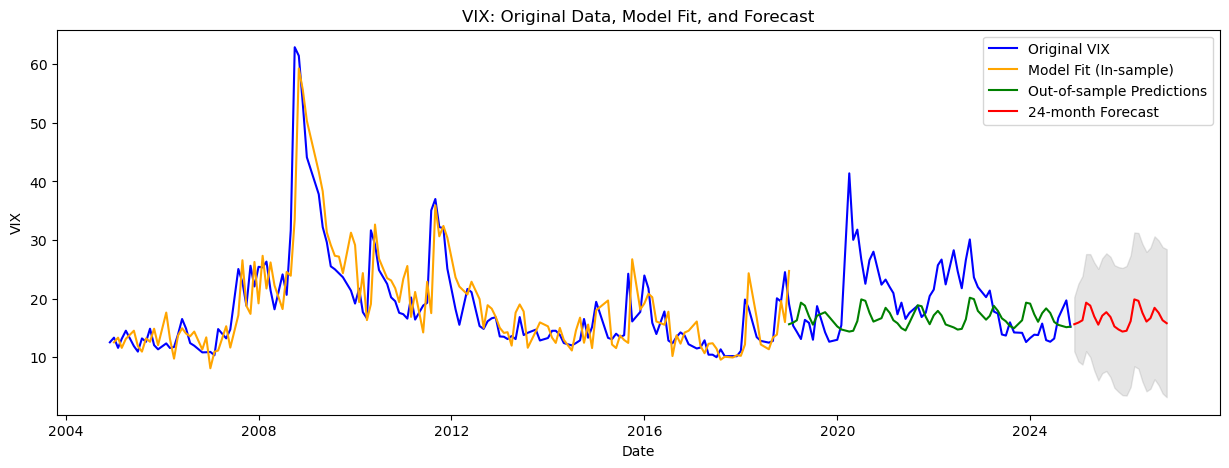

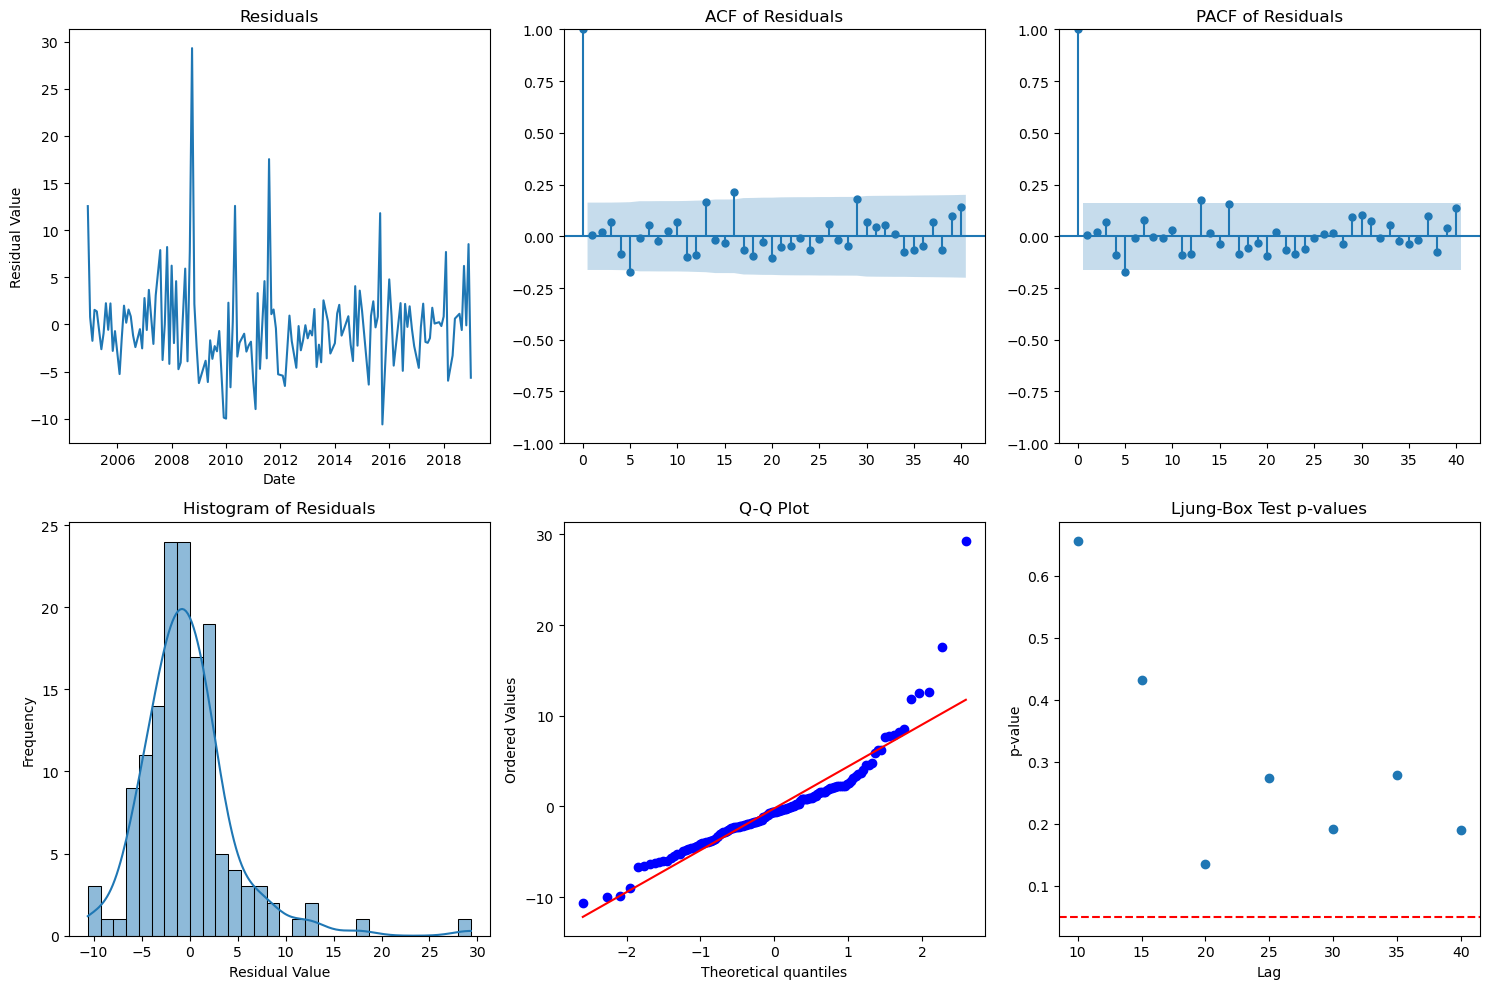

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   7.718868   0.656276
15  15.279712   0.431463
20  27.004753   0.135130
25  28.757499   0.274180
30  36.542367   0.190854
35  39.402037   0.279420
40  47.615166   0.190464

In-sample R-squared: 0.6844
In-sample RMSE: 4.9318
In-sample MAPE: 0.1782
In-sample Directional Accuracy: 0.4583

Out-of-sample R-squared: -0.2934
Out-of-sample RMSE: 6.6675
Out-of-sample MAPE: 0.2269
Out-of-sample Directional Accuracy: 0.5082

SARIMA R-squared: 0.5304
SARIMA RMSE: 5.5175
SARIMA MAPE: 0.1929
SARIMA Directional Accuracy: 0.4780


In [28]:
# Split data into in-sample and out-of-sample datasets
split_date = "2019-01-01"
in_sample = VIX[:split_date]
out_of_sample = VIX[split_date:]

# Fit SARIMAX model on the in-sample data only
model = SARIMAX(in_sample, order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
sarima_results = model.fit()

# Generate in-sample predictions
sarima_in_sample_predictions = sarima_results.get_prediction(start=in_sample.index[0], end=in_sample.index[-1]).predicted_mean

# Generate out-of-sample predictions
sarima_out_of_sample_predictions = sarima_results.get_forecast(steps=len(out_of_sample)).predicted_mean
sarima_out_of_sample_predictions.index = out_of_sample.index  # Align indices

# Generate forecasted values and confidence intervals for 6 months
forecast_steps = 24
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
sarima_forecasted_values = sarima_forecast.predicted_mean

sarima_conf_int = sarima_forecast.conf_int(alpha=0.32)

# Define forecast dates explicitly
last_date = VIX.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=forecast_steps, freq="M")

# Plot original VIX, model fit, and forecast
plt.figure(figsize=(15, 5))
plt.plot(VIX, label='Original VIX', color='blue')
plt.plot(sarima_in_sample_predictions.iloc[1:], label='Model Fit (In-sample)', color='orange')
plt.plot(sarima_out_of_sample_predictions, label='Out-of-sample Predictions', color='green')
plt.plot(forecast_dates, sarima_forecasted_values, label='24-month Forecast', color='red')
plt.fill_between(forecast_dates,
                 sarima_conf_int.iloc[:, 0],
                 sarima_conf_int.iloc[:, 1],
                 color='gray', alpha=0.2)
plt.title('VIX: Original Data, Model Fit, and Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

# Calculate residuals
sarima_residuals = sarima_results.resid

# Create a 2x3 subplot for residual analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('SARIMA - Residual Analysis', fontsize=16)

# Plot residuals
axes[0, 0].plot(sarima_residuals)
axes[0, 0].set_title('Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual Value')

# ACF of residuals
plot_acf(sarima_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title('ACF of Residuals')

# PACF of residuals
plot_pacf(sarima_residuals, ax=axes[0, 2], lags=40)
axes[0, 2].set_title('PACF of Residuals')

# Histogram of residuals
sns.histplot(sarima_residuals, kde=True, ax=axes[1,0], bins=30, edgecolor='black')
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')

# Q-Q plot
qq = stats.probplot(sarima_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# Ljung-Box test
lb_results = acorr_ljungbox(sarima_residuals, lags=[10, 15, 20, 25, 30, 35, 40])
axes[1, 2].scatter(lb_results.index, lb_results['lb_pvalue'])
axes[1, 2].axhline(y=0.05, color='r', linestyle='--')
axes[1, 2].set_title('Ljung-Box Test p-values')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].set_ylabel('p-value')

plt.tight_layout()
plt.show()

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
print(lb_results)

# Calculate metrics
sarima_in_sample_r2 = r2_score(in_sample, sarima_in_sample_predictions)
sarima_in_sample_rmse = root_mean_squared_error(in_sample, sarima_in_sample_predictions)
sarima_in_sample_mape = mean_absolute_percentage_error(in_sample, sarima_in_sample_predictions)
sarima_in_sample_da = mean_directional_accuracy(in_sample, sarima_in_sample_predictions)

sarima_out_sample_r2 = r2_score(out_of_sample, sarima_out_of_sample_predictions)
sarima_out_sample_rmse = root_mean_squared_error(out_of_sample, sarima_out_of_sample_predictions)
sarima_out_sample_mape = mean_absolute_percentage_error(out_of_sample, sarima_out_of_sample_predictions)
sarima_out_sample_da = mean_directional_accuracy(out_of_sample, sarima_out_of_sample_predictions)

sarima_combined_predictions = pd.concat([sarima_in_sample_predictions, sarima_out_of_sample_predictions])
sarima_combined_predictions = sarima_combined_predictions[~sarima_combined_predictions.index.duplicated(keep='first')]

sarima_r2 = r2_score(VIX, sarima_combined_predictions)
sarima_rmse = root_mean_squared_error(VIX, sarima_combined_predictions)
sarima_mape = mean_absolute_percentage_error(VIX, sarima_combined_predictions)
sarima_da = mean_directional_accuracy(VIX, sarima_combined_predictions)


# Print results
print(f"\nIn-sample R-squared: {sarima_in_sample_r2:.4f}")
print(f"In-sample RMSE: {sarima_in_sample_rmse:.4f}")
print(f"In-sample MAPE: {sarima_in_sample_mape:.4f}")
print(f"In-sample Directional Accuracy: {sarima_in_sample_da:.4f}")
print(f"\nOut-of-sample R-squared: {sarima_out_sample_r2:.4f}")
print(f"Out-of-sample RMSE: {sarima_out_sample_rmse:.4f}")
print(f"Out-of-sample MAPE: {sarima_out_sample_mape:.4f}")
print(f"Out-of-sample Directional Accuracy: {sarima_out_sample_da:.4f}")
print(f"\nSARIMA R-squared: {sarima_r2:.4f}")
print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAPE: {sarima_mape:.4f}")
print(f"SARIMA Directional Accuracy: {sarima_da:.4f}")



In [29]:
data_interim = data_filled.reset_index(drop=True)
data_interim.set_index('Date', inplace=True)

data_interim.index = pd.to_datetime(data_interim.index)

exog = data_interim[[ 'Unemployment Rate','CPI','Fed Rate','BBB Rate','GDP','SP500 ^GSPC.1']]

In [30]:
# Rename specific columns using a dictionary
exog.rename(columns={'SP500 ^GSPC.1': 'S&P Volume'}, inplace=True)


In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
#Scaling the data for the model
scaler = StandardScaler()

scaled_exog = pd.DataFrame(scaler.fit_transform(exog), columns=exog.columns)
scaled_VIX = pd.DataFrame(scaler.fit_transform(VIX), columns=VIX.columns)

## Understanding the influence of economic factors on VIX

In [33]:
import dcor
from scipy.optimize import curve_fit
from statsmodels.nonparametric.smoothers_lowess import lowess

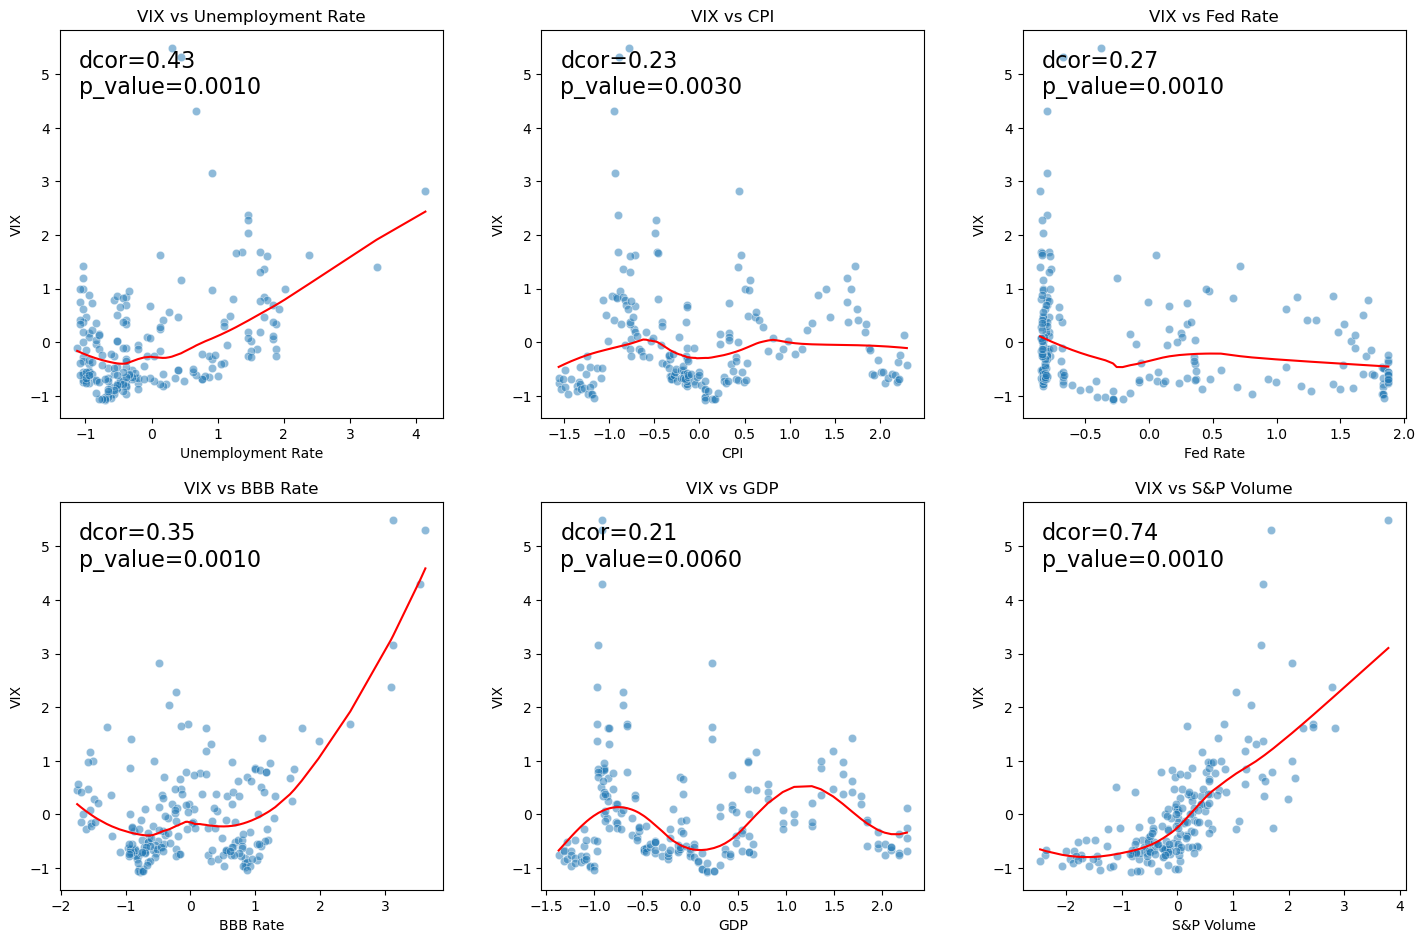

In [34]:
def fourier_func(x, a0, a1, b1, w):
    return a0 + a1 * np.cos(w * x) + b1 * np.sin(w * x)

def fourier_lowess_fit(x, y, lowess_frac=0.7):
    # Sort x and y based on x values
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Fourier fit
    try:
        initial_guess = [np.mean(y), 1, 0, 0.1]
        params, _ = curve_fit(fourier_func, x_sorted, y_sorted, 
                            p0=initial_guess, 
                            maxfev=5000000, 
                            method='trf',
                            bounds=([-np.inf, -np.inf, -np.inf, 0], 
                                   [np.inf, np.inf, np.inf, np.inf]))
        y_fourier = fourier_func(x_sorted, *params)
        
        # LOWESS smoothing on Fourier residuals
        residuals = y_sorted - y_fourier
        smoothed_residuals = lowess(residuals, x_sorted, frac=lowess_frac, it=1)[:, 1]
        
        # Combine Fourier and smoothed residuals
        y_combined = y_fourier + smoothed_residuals
        
        return x_sorted, y_combined
    except:
        # Fallback to pure LOWESS if Fourier fitting fails
        return x_sorted, lowess(y_sorted, x_sorted, frac=lowess_frac, it=1)[:, 1]

feature_columns = scaled_exog.columns

n_cols = 3
n_rows = (len(feature_columns) + 2) // 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=4.0)

dcor_results = {}

for i, feature in enumerate(feature_columns):
    row = i // n_cols
    col = i % n_cols
    
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.scatterplot(x=scaled_exog[feature].squeeze(), 
                   y=scaled_VIX.squeeze(), 
                   ax=ax, 
                   alpha=0.5)

    dc = dcor.distance_correlation(scaled_exog[feature].squeeze(), 
                                 scaled_VIX.squeeze())
    p_value = dcor.independence.distance_covariance_test(
        scaled_exog[feature].squeeze(), 
        scaled_VIX.squeeze(), 
        exponent=1.0,
        num_resamples=1000
    )

    dcor_results[feature] = {'dcor': dc, 'p_value': p_value}

    x_data = scaled_exog[feature].values
    y_data = scaled_VIX['VIX'].values

    try:
        x_sorted, y_fit = fourier_lowess_fit(x_data, y_data)
        ax.plot(x_sorted, y_fit, color='red', label='Fourier-LOWESS')
    except Exception as e:
        print(f'Could not perform fit for {feature}: {e}')

    ax.text(0.05, 0.95, 
            f'dcor={dc:.2f}\np_value={p_value.pvalue:.4f}',
            transform=ax.transAxes,
            fontsize=16, 
            verticalalignment='top')
    
    ax.set_title(f'VIX vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('VIX')
    # ax.legend()

# Remove unused subplots
for i in range(len(feature_columns), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.show()

dcor_df = pd.DataFrame.from_dict(dcor_results, orient='index')


In [35]:
log_exog = np.log1p(exog)

diff_log_exog = log_exog.diff() 
diff_log_exog.iloc[0] = 0

## SARIMAX model


The SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model extends SARIMA by including exogenous variables:
$$(1 - \phi_1 B - \phi_2 B^2)(1 - \Phi_1 B^{12}-\Phi_2 B^{24})(1-B)y_t = \beta X_t + (1 + \theta_1 B + \theta_2 B^2)(1 + \Theta_1 B^{12} + \Theta_2 B^{24})\epsilon_t$$

where:
- $X_t$ represents the exogenous variables
- and $\beta$ their coefficients

### Key Components

1. **Autoregressive (AR) terms**: $\phi_1B$ and $\phi_2B^2$ capture the relationship between an observation and its lagged values.

2. **Seasonal AR terms**: $\Phi_1B^{12}$ and $\Phi_2B^{24}$ account for seasonal patterns in the data.

3. **Differencing**: $(1-B)$ removes trends and makes the series stationary.

4. **Moving Average (MA) terms**: $\theta_1B$ and $\theta_2B^2$ represent the relationship between an observation and past forecast errors.

5. **Seasonal MA terms**: $\Theta_1B^{12}$ and $\Theta_2B^{24}$ account for seasonal patterns in the forecast errors.

6. **Exogenous variables**: $\beta X_t$ allows the model to incorporate external factors that may influence the time series.

### Advantages of SARIMAX

1. **Improved forecasting**: By including relevant external variables, SARIMAX can capture additional information and potentially improve forecast accuracy.

2. **Flexibility**: It can handle both endogenous dynamics and exogenous influences simultaneously.

3. **Interpretability**: The model provides insights into how external factors affect the time series, which can be valuable for decision-making.

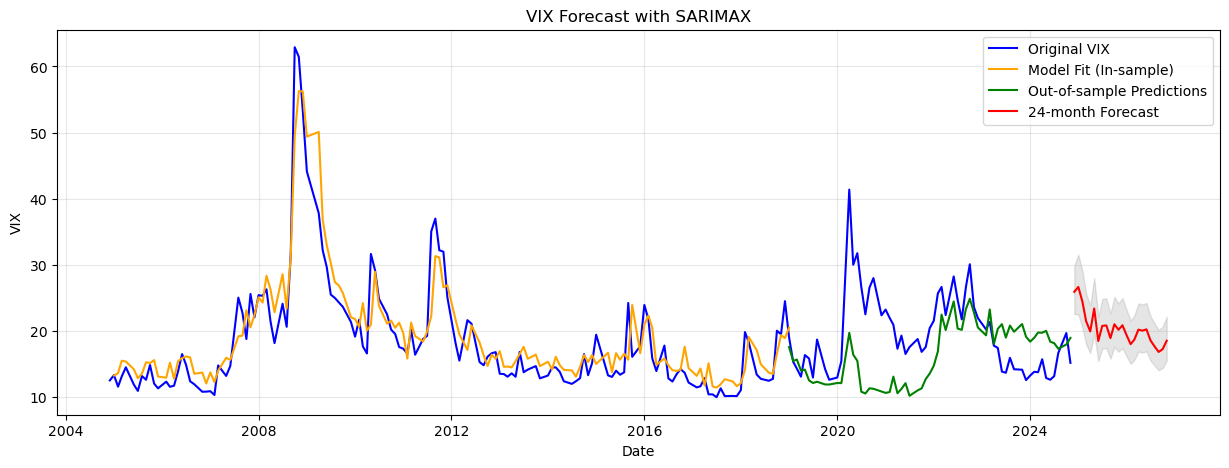

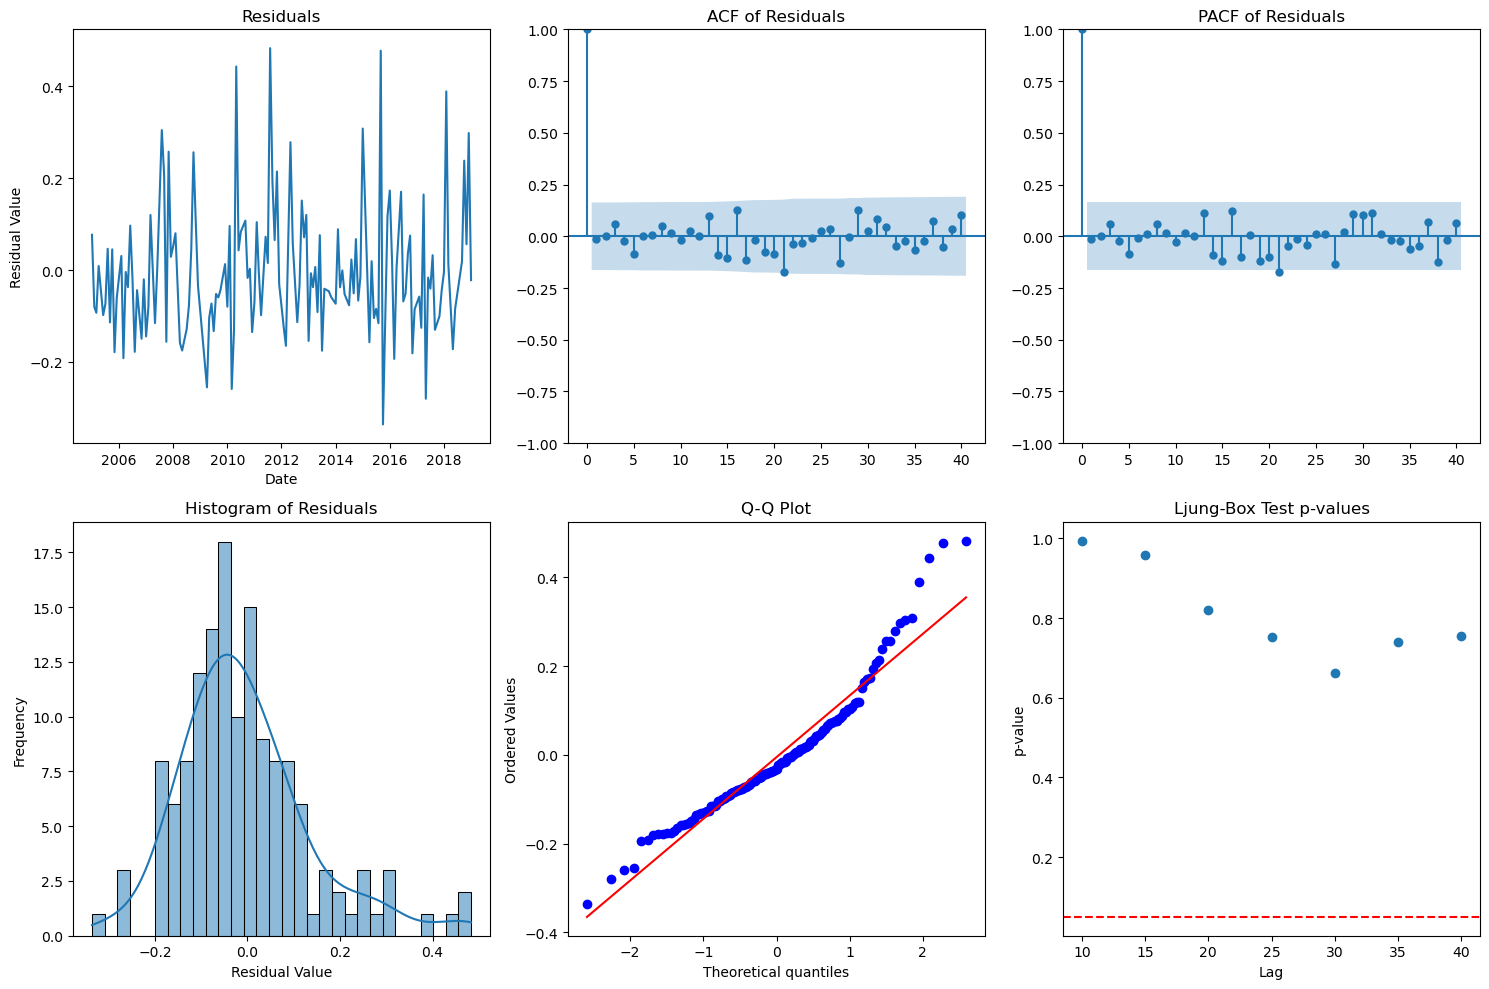

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   2.199324   0.994572
15   6.987687   0.957991
20  14.210854   0.819646
25  19.893531   0.752388
30  26.267115   0.661430
35  29.302064   0.739249
40  33.517610   0.755658

In-sample R-squared: 0.8553
In-sample RMSE: 1.8291
In-sample MAPE: 0.1044
In-sample Directional Accuracy: 0.6154

Out-of-sample R-squared: -0.8079
Out-of-sample RMSE: 2.8077
Out-of-sample MAPE: 0.2866
Out-of-sample Directional Accuracy: 0.6721

SARIMAX R-squared: 0.6143
SARIMAX RMSE: 5.0057
SARIMAX MAPE: 0.1857
SARIMAX Directional Accuracy: 0.6324


In [36]:
# Split the data
split_date = "2019-01-01"
in_sample = log_VIX[:split_date]
out_of_sample = log_VIX[split_date:]

# Split exogenous variables
exog_in_sample = log_exog[:split_date]
exog_out_of_sample = log_exog[split_date:]

# Fit SARIMAX model
model = SARIMAX(in_sample, 
                exog=exog_in_sample, 
                order=(2, 1, 2),
                seasonal_order=(2, 0, 2, 12),
                enforce_stationarity=True,
                enforce_invertibility=True)

sarimax_results = model.fit(disp=False, 
                   maxiter=1000,
                   method='powell',
                   cov_type='robust')

# Generate predictions and transform back to original scale
sarimax_in_sample_predictions = np.exp(sarimax_results.get_prediction(
    start=in_sample.index[0], 
    end=in_sample.index[-1],
    exog=exog_in_sample
).predicted_mean) 

sarimax_out_of_sample_predictions = np.exp(sarimax_results.get_forecast(
    steps=len(out_of_sample),
    exog=exog_out_of_sample
).predicted_mean) 
sarimax_out_of_sample_predictions.index = out_of_sample.index

# Generate future forecast
forecast_steps = 24
sarimax_forecast = sarimax_results.get_forecast(
    steps=forecast_steps,
    exog=exog_out_of_sample.tail(24)
)
sarimax_forecasted_values = np.exp(sarimax_forecast.predicted_mean) 
conf_int = np.exp(sarimax_forecast.conf_int(alpha=0.32)) 

# Define forecast dates
last_date = VIX.index[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.offsets.MonthEnd(1), 
    periods=forecast_steps, 
    freq="M"
)

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(VIX.index, VIX, 
         label='Original VIX', 
         color='blue')
plt.plot(sarimax_in_sample_predictions.index[1:], sarimax_in_sample_predictions.iloc[1:], 
         label='Model Fit (In-sample)', 
         color='orange')
plt.plot(sarimax_out_of_sample_predictions.index, sarimax_out_of_sample_predictions, 
         label='Out-of-sample Predictions', 
         color='green')
plt.plot(forecast_dates, sarimax_forecasted_values, 
         label='24-month Forecast', 
         color='red')
plt.fill_between(forecast_dates,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='gray', 
                 alpha=0.2)

plt.title('VIX Forecast with SARIMAX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate residuals
sarimax_residuals = sarimax_results.resid[1:]

# Create a 2x3 subplot for residual analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('Residual Analysis', fontsize=16)

# Plot residuals
axes[0, 0].plot(sarimax_residuals)
axes[0, 0].set_title('Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual Value')

# ACF of residuals
plot_acf(sarimax_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title('ACF of Residuals')

# PACF of residuals
plot_pacf(sarimax_residuals, ax=axes[0, 2], lags=40)
axes[0, 2].set_title('PACF of Residuals')

# Histogram of residuals
sns.histplot(sarimax_residuals, kde=True, ax=axes[1,0], bins=30, edgecolor='black')
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')

# Q-Q plot
qq = stats.probplot(sarimax_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# Ljung-Box test
lb_results = acorr_ljungbox(sarimax_residuals, lags=[10, 15, 20, 25, 30, 35, 40])
axes[1, 2].scatter(lb_results.index, lb_results['lb_pvalue'])
axes[1, 2].axhline(y=0.05, color='r', linestyle='--')
axes[1, 2].set_title('Ljung-Box Test p-values')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].set_ylabel('p-value')

plt.tight_layout()
plt.show()

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
print(lb_results)

# Calculate metrics
sarimax_in_sample_r2 = r2_score(np.exp(in_sample[1:]), sarimax_in_sample_predictions[1:])
sarimax_in_sample_rmse = np.sqrt(root_mean_squared_error(np.exp(in_sample[1:]), sarimax_in_sample_predictions[1:]))
sarimax_in_sample_mape = mean_absolute_percentage_error(np.exp(in_sample[1:]), sarimax_in_sample_predictions[1:])
sarimax_in_sample_da = mean_directional_accuracy(np.exp(in_sample[1:]), sarimax_in_sample_predictions[1:])

sarimax_out_sample_r2 = r2_score(np.exp(out_of_sample), sarimax_out_of_sample_predictions)
sarimax_out_sample_rmse = np.sqrt(root_mean_squared_error(np.exp(out_of_sample), sarimax_out_of_sample_predictions))
sarimax_out_sample_mape = mean_absolute_percentage_error(np.exp(out_of_sample), sarimax_out_of_sample_predictions)
sarimax_out_sample_da = mean_directional_accuracy(np.exp(out_of_sample), sarimax_out_of_sample_predictions)

sarimax_combined_predictions = pd.concat([sarimax_in_sample_predictions[1:], sarimax_out_of_sample_predictions])
sarimax_combined_predictions = sarimax_combined_predictions[~sarimax_combined_predictions.index.duplicated(keep='first')]

sarimax_r2 = r2_score(VIX[1:], sarimax_combined_predictions)
sarimax_rmse = root_mean_squared_error(VIX[1:], sarimax_combined_predictions)
sarimax_mape = mean_absolute_percentage_error(VIX[1:], sarimax_combined_predictions)
sarimax_da = mean_directional_accuracy(VIX[1:], sarimax_combined_predictions)


# Print results
print(f"\nIn-sample R-squared: {sarimax_in_sample_r2:.4f}")
print(f"In-sample RMSE: {sarimax_in_sample_rmse:.4f}")
print(f"In-sample MAPE: {sarimax_in_sample_mape:.4f}")
print(f"In-sample Directional Accuracy: {sarimax_in_sample_da:.4f}")
print(f"\nOut-of-sample R-squared: {sarimax_out_sample_r2:.4f}")
print(f"Out-of-sample RMSE: {sarimax_out_sample_rmse:.4f}")
print(f"Out-of-sample MAPE: {sarimax_out_sample_mape:.4f}")
print(f"Out-of-sample Directional Accuracy: {sarimax_out_sample_da:.4f}")
print(f"\nSARIMAX R-squared: {sarimax_r2:.4f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.4f}")
print(f"SARIMAX MAPE: {sarimax_mape:.4f}")
print(f"SARIMAX Directional Accuracy: {sarimax_da:.4f}")

## GARCH model

GARCH (Generalized AutoRegressive Conditional Heteroskedasticity) model analyzes the time series data to estimate volatility. It assumes that the variance of the error term follows an autoregressive moving average process, and provides different volatility estimates over time.

The GARCH(1,1) model is degined as:
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

where:
- $\sigma_t^2$ is the conditional variance
- $\epsilon_t$ are the residuals
- $\omega, \alpha_1, \beta_1$ are parameters to be estimated


### Components of GARCH(1,1)

1. **Constant term** ($\omega$): This represents the long-term average volatility. It must be positive to ensure a positive conditional variance.

2. **ARCH term** ($\alpha_1 \epsilon_{t-1}^2$): This captures the impact of recent shocks on volatility. A large residual in the previous period leads to higher volatility in the current period.

3. **GARCH term** ($\beta_1 \sigma_{t-1}^2$): This represents the persistence of volatility from the previous period. It allows past conditional variances to influence the current conditional variance.

### Key Properties

- **Stationarity**: For the GARCH(1,1) process to be stationary, the sum of $\alpha_1$ and $\beta_1$ must be less than 1 ($\alpha_1 + \beta_1 < 1$).

- **Persistence**: The sum $\alpha_1 + \beta_1$ measures the persistence of volatility shocks. Values close to 1 indicate high persistence.

- **Unconditional variance**: The long-run average variance is given by $\frac{\omega}{1-\alpha_1-\beta_1}$, assuming $\alpha_1 + \beta_1 < 1$.


In [37]:
import arch
from arch import arch_model

In [38]:
import random
import torch

# Set random seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

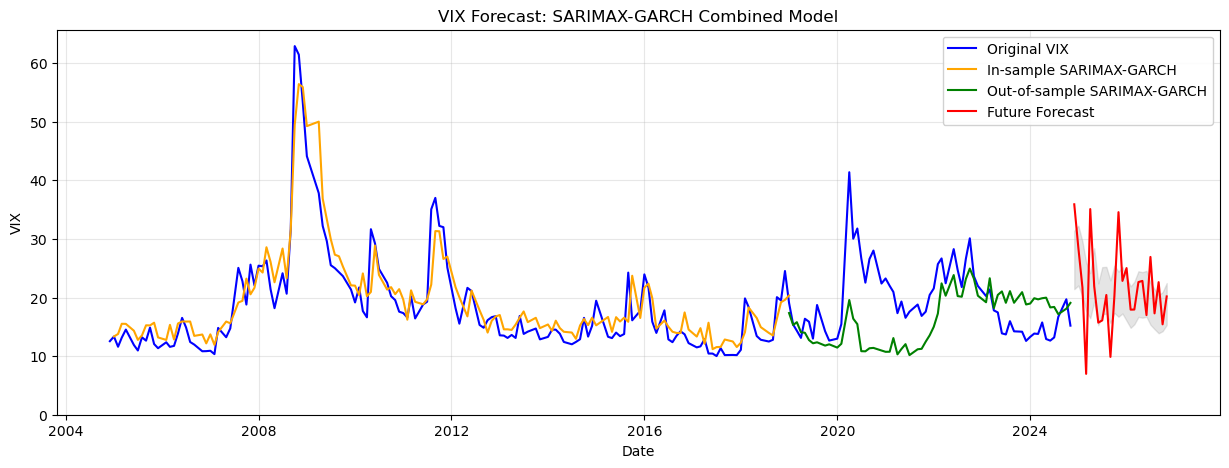

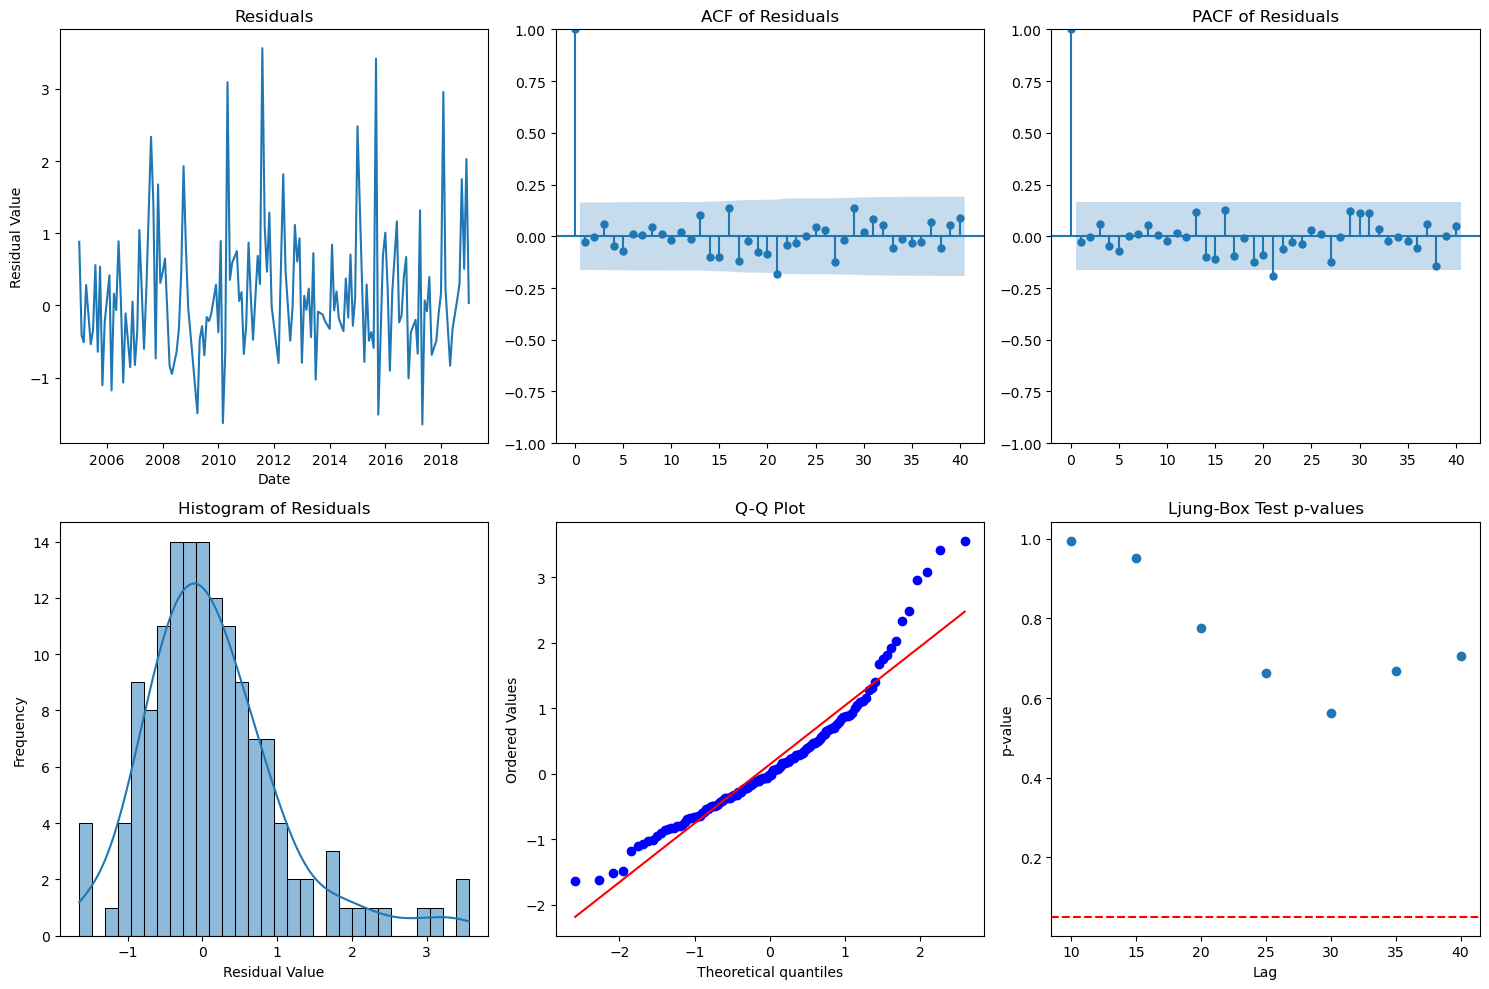


Jarque-Bera Test for Normality:
Statistic: 66.7165, p-value: 0.0000

Ljung-Box Test for Autocorrelation:
      lb_stat  lb_pvalue
10   2.106279   0.995459
15   7.238835   0.950680
20  15.015917   0.775496
25  21.512908   0.663690
30  28.175327   0.561146

Ljung-Box Test for ARCH effects:
      lb_stat  lb_pvalue
10   4.542106   0.919597
15  10.669891   0.775625
20  14.047256   0.828092
25  19.336257   0.780719
30  21.425764   0.874104

SARIMAX-GARCH R-squared: 0.6149
SARIMAX-GARCH RMSE: 5.0018
SARIMAX-GARCH MAPE: 0.1856
SARIMAX-GARCH Directional Accuracy: 0.6471


In [39]:
# GARCH model
garch_model = arch_model(sarimax_residuals, vol='GARCH', p=1, q=1, dist='studentsT', rescale=False)
garch_results = garch_model.fit(disp='off', update_freq=5, options={'maxiter':10000})

# Generate volatility forecasts
in_sample_volatility = garch_results.conditional_volatility
total_forecast_length = len(out_of_sample) + 24  # 24 months ahead
garch_forecast = garch_results.forecast(horizon=total_forecast_length, method='simulation', reindex=False)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

df = garch_results.params['nu']
rng = np.random.default_rng(42)

# Combine SARIMAX and GARCH
# In-sample combinations
in_sample_combined = (sarimax_in_sample_predictions[1:] + 
                      in_sample_volatility * rng.standard_t(df, size=len(sarimax_in_sample_predictions[1:])))

# Out-of-sample combinations
out_sample_combined = (sarimax_out_of_sample_predictions + 
                       forecast_volatility[:len(out_of_sample)] * rng.standard_t(df, size=len(out_of_sample)))

# Future forecast combinations
forecast_horizon = 24
future_forecast = sarimax_results.get_forecast(steps=forecast_horizon, exog=exog_out_of_sample.tail(24))
future_forecast_mean = future_forecast.predicted_mean
future_forecast_combined = np.exp(future_forecast_mean + 
                            forecast_volatility[len(out_of_sample):] * rng.standard_t(df, size=forecast_horizon))

# Ensure non-negative values
in_sample_combined = np.maximum(in_sample_combined, 0)
out_sample_combined = np.maximum(out_sample_combined, 0)
future_forecast_combined = np.maximum(future_forecast_combined, 0)

# Plot Results
plt.figure(figsize=(15, 5))
plt.plot(VIX.index, VIX, label='Original VIX', color='blue')
plt.plot(sarimax_in_sample_predictions.index[1:], in_sample_combined, 
         label='In-sample SARIMAX-GARCH', color='orange')
plt.plot(sarimax_out_of_sample_predictions.index, out_sample_combined, 
         label='Out-of-sample SARIMAX-GARCH', color='green')
plt.plot(forecast_dates, future_forecast_combined, 
         label='Future Forecast', color='red')

# Calculate 68% confidence intervals (approximately one standard deviation)
t_multiplier = stats.t.ppf(0.84, df)  # 68% CI using t-distribution
lower_bound = np.exp(future_forecast_mean - t_multiplier * forecast_volatility[len(out_of_sample):])
upper_bound = np.exp(future_forecast_mean + t_multiplier * forecast_volatility[len(out_of_sample):])

# Plot with 68% confidence intervals
plt.fill_between(forecast_dates, lower_bound, upper_bound,
                 color='gray', alpha=0.2)

plt.title('VIX Forecast: SARIMAX-GARCH Combined Model')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)  # VIX cannot be negative
plt.legend(loc='best', framealpha=0.9)
plt.show()

# Calculate standardized residuals
standardized_residuals = garch_results.resid / garch_results.conditional_volatility

# Create subplots for residual analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Residuals Time Series
axes[0, 0].plot(standardized_residuals)
axes[0, 0].set_title('Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual Value')

# Plot 2: ACF
plot_acf(standardized_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title('ACF of Residuals')

# Plot 3: PACF
plot_pacf(standardized_residuals, ax=axes[0, 2], lags=40)
axes[0, 2].set_title('PACF of Residuals')

# Plot 4: Histogram
sns.histplot(standardized_residuals, kde=True, ax=axes[1, 0], bins=30)
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')

# Plot 5: Q-Q Plot
stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# Plot 6: Ljung-Box Test
lb_results = acorr_ljungbox(standardized_residuals, lags=[10, 15, 20, 25, 30, 35, 40])
axes[1, 2].scatter(lb_results.index, lb_results['lb_pvalue'])
axes[1, 2].axhline(y=0.05, color='r', linestyle='--')
axes[1, 2].set_title('Ljung-Box Test p-values')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].set_ylabel('p-value')

plt.tight_layout()
plt.show()

# Additional Statistical Tests
print("\nJarque-Bera Test for Normality:")
jb_test = stats.jarque_bera(standardized_residuals)
print(f"Statistic: {jb_test.statistic:.4f}, p-value: {jb_test.pvalue:.4f}")

print("\nLjung-Box Test for Autocorrelation:")
lb_test = acorr_ljungbox(standardized_residuals, lags=[10, 15, 20, 25, 30])
print(lb_test)

print("\nLjung-Box Test for ARCH effects:")
lb_test_squared = acorr_ljungbox(standardized_residuals**2, lags=[10, 15, 20, 25, 30])
print(lb_test_squared)

# Performance metrics
sarimax_garch_combined_predictions = pd.concat([in_sample_combined, out_sample_combined])
sarimax_garch_combined_predictions = sarimax_garch_combined_predictions[~sarimax_garch_combined_predictions.index.duplicated(keep='first')]

sarimax_garch_r2 = r2_score(VIX[1:], sarimax_garch_combined_predictions)
sarimax_garch_rmse = root_mean_squared_error(VIX[1:], sarimax_garch_combined_predictions)
sarimax_garch_mape = mean_absolute_percentage_error(VIX[1:], sarimax_garch_combined_predictions)
sarimax_garch_da = mean_directional_accuracy(VIX[1:], sarimax_garch_combined_predictions)


print(f"\nSARIMAX-GARCH R-squared: {sarimax_garch_r2:.4f}")
print(f"SARIMAX-GARCH RMSE: {sarimax_garch_rmse:.4f}")
print(f"SARIMAX-GARCH MAPE: {sarimax_garch_mape:.4f}")
print(f"SARIMAX-GARCH Directional Accuracy: {sarimax_garch_da:.4f}")

In [40]:
# from scipy.optimize import minimize

In [41]:
# class StudentTCopula:
#     def __init__(self, dim):
#         self.dim = dim
#         self.df = None
#         self.corr = None

#     def _t_cdf(self, x, df):
#         return stats.t.cdf(x, df)
    
#     def _t_ppf(self, u, df):
#         return stats.t.ppf(u, df)
    
#     def _log_likelihood(self, params):
#         df, corr_params = params[0], params[1:]
#         corr = self._params_to_corr(corr_params)

#         U = np.column_stack([self._t_ppf(self.U[:, i], df) for i in range(self.dim)])

#         log_det = np.log(np.linalg.det(corr))
#         inv_corr = np.linalg.inv(corr)

#         S = np.sum(U @ inv_corr * U, axis=1)

#         ll = (
#             np.sum(stats.t.logpdf(U, df).sum(axis=1)) 
#             - 0.5 * log_det * len(self.U)
#             - 0.5 * (self.dim + df) * np.sum(np.log(1 + S / df))
#             + 0.5 * (df + 1) * np.sum(np.log(1 + U**2 / df).sum(axis=1))
#         )

#         return -ll
    
#     def _params_to_corr(self, params):
#         L = np.zeros((self.dim, self.dim))
#         L[np.tril_indices(self.dim, k=-1)] = params
#         corr = L @ L.T
#         corr += np.eye(self.dim)
#         D = np.diag(1 / np.sqrt(np.diag(corr)))
#         corr = D @ corr @ D
#         return corr
    
#     def fit(self, U):
#         self.U = U

#         initial_df = 5.0
#         initial_corr_params = np.zeros(self.dim * (self.dim - 1) // 2)
#         initial_params = np.concatenate(([initial_df], initial_corr_params))

#         bounds = [(2.01, 100)] + [(-1, 1)] * len(initial_corr_params)

#         result = minimize(self._log_likelihood, initial_params, method='L-BFGS-B', bounds=bounds)

#         self.df, corr_params = result.x[0], result.x[1:]
#         self.corr = self._params_to_corr(corr_params)

#     def sample(self, n_samples):
#         Z = np.random.multivariate_normal(np.zeros(self.dim), self.corr, size=n_samples)
#         S = np.random.chisquare(self.df, size=n_samples) / self.df
#         T = Z / np.sqrt(S)[:, None]
#         U = self._t_cdf(T, self.df)
#         return U

In [42]:
# copula_data = sarimax_residuals.rank() / (len(sarimax_residuals) + 1)

# t_copula = StudentTCopula(dim=copula_data.shape[1])
# t_copula.fit(copula_data.values)

# #Generate samples
# num_samples = len(sarimax_residuals)
# copula_samples = t_copula.sample(num_samples)

# #Transform copula samples back to original scale
# def inverse_empirical_cdf(u, x):
#     return np.interp(u, np.linspace(0, 1, len(x)), np.sort(x))

# copula_residuals = np.column_stack([
#     inverse_empirical_cdf(copula_samples[:, i], sarimax_residuals.iloc[:, i])
#     for i in range(sarimax_residuals.shape[1])
# ])

## Copulas

Copula theory is a powerful statistical framework for modeling the dependence structure between multiple variables, particularly useful in financial time series analysis. In the context of VIX analysis, copulas offer several advantages:


Copulas are functions that join or "couple" multivariate distribution functions to their one-dimensional marginal distribution functions. The key theorem underlying copula theory is Sklar's theorem, which states that any multivariate distribution can be expressed in terms of its marginals and a copula function:

$$ F(x_1, ..., x_n) = C(F_1(x_1), ..., F_n(x_n)) $$

Where $F(.)$ is the joint cumulative distribution function, $F_i(.)$ are the marginal distributions, and C is the copula function.

### Advantages in VIX Analysis

1. **Flexibility**: Copulas allow for modeling complex dependence structures between the VIX and other financial variables without assuming specific marginal distributions.

2. **Tail Dependence**: Copulas can capture non-linear dependencies and extreme co-movements, which are crucial in VIX analysis due to its role as a volatility index.

3. **Separation of Marginals and Dependence**: This separation allows for more accurate modeling of individual variables' behavior and their joint dynamics.


## Copula-GARCH model

The Copula-GARCH model combines copula theory with GARCH modeling to capture both the time-varying volatility and the dependence structure between financial time series. This approach allows for more flexible modeling of multivariate financial data compared to traditional methods.

The EGARCH model, which is often used in Copula-GARCH frameworks, is defined as:
$$log(\sigma_t^2) = \omega + \alpha_1 \left( \frac{|\epsilon_{t-1}|}{\sigma_{t-1}} - E \left[\frac{|\epsilon_{t-1}|}{\sigma_{t-1}}\right]\right) + \gamma_1 \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta_1 log(\sigma_{t-1}^2) $$

where:
- $\sigma_t^2$ is the conditional variance at time t
- $\epsilon_t$ is the innovation (residual) at time t
- $\omega$ is the model constant
- $\alpha_1$ is the ARCH parameter that measures the magnitude effect of previous shocks
- $\gamma_1$ is the leverage parameter that captures asymmetric effects of positive and negative shocks
- $\beta_1$ is the GARCH parameter that measures the persistence of volatility
- $E\left[\frac{|\epsilon_{t-1}|}{\sigma_{t-1}}\right]$ is the expected value of the absolute standardized residuals


This model allows for asymmetric effects of positive and negative shocks on volatility, with $\gamma_1$ capturing this asymmetry. When $\gamma_1 < 0$, negative shocks have a larger impact on future volatility than positive shocks of the same magnitude.



\
\
The Copula-GARCH approach typically involves the following steps:
- Fitting univariate GARCH models to each time series
- Extracting standardized residuals from these models
- Estimating the parameters of a chosen copula function using these residuals
- Using the fitted copula to model the dependence structure between the time series

This method allows for separate modeling of the marginal distributions and the dependence structure, providing greater flexibility in capturing complex relationships between financial variables.

The Copula-GARCH model combines the strengths of copula theory and GARCH modeling:

1. **GARCH Component**: Models the time-varying volatility of individual series.
   
   $$ \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$

2. **Copula Component**: Captures the dependence structure between standardized residuals.

   $$ C(u_1, u_2) = P(U_1 \leq u_1, U_2 \leq u_2) $$

3. **Combined Model**: The joint distribution of returns is modeled as:

   $$ F(r_1, r_2) = C(F_1(r_1), F_2(r_2)) $$

   Where $F_i(.)$ are GARCH-based marginal distributions and C is the copula function.

This approach is particularly suitable for VIX analysis because it can capture both the volatility clustering typical of financial time series and the complex, often non-linear, relationships between the VIX and other market variables. The model's ability to handle tail dependence is crucial for risk management and understanding market behavior during extreme events, which are often of particular interest when studying the VIX.

In [43]:
from scipy.stats import rankdata

In [44]:
if isinstance(standardized_residuals, pd.Series):
    standardized_residuals  = standardized_residuals.to_frame(name='residuals')

In [45]:
def empirical_copula(data):
    n, d = data.shape
    ranks = rankdata(data, axis=0)
    return ranks / (n + 1)

In [46]:
copula = empirical_copula(standardized_residuals)
n_samples = len(standardized_residuals)
sampled_ranks = np.random.uniform(0, 1, size=(n_samples, standardized_residuals.shape[1]))

In [47]:
def inverse_transform(u, x):
    return np.interp(u, np.linspace(0, 1, len(x)), np.sort(x))

In [48]:
# copula_residuals = invest_empirical_cdf(copula_samples.values.flatten(), sarimax_residuals)
copula_residuals = np.column_stack([
    inverse_transform(sampled_ranks[:, i], standardized_residuals.iloc[:, i])
    for i in range(standardized_residuals.shape[1])
])

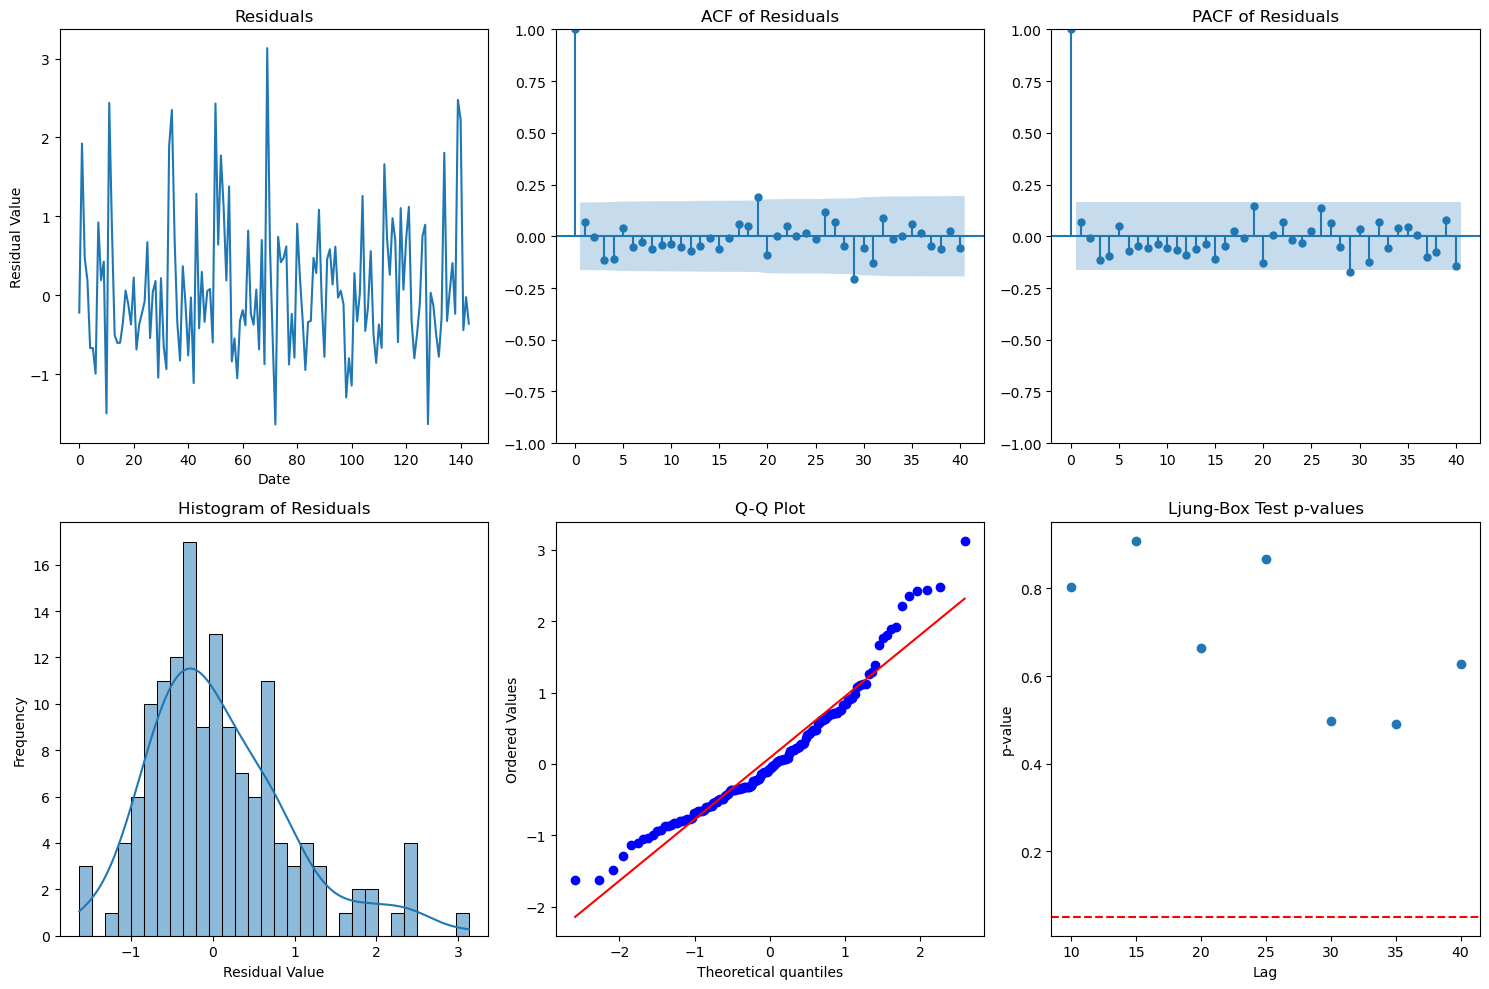

In [49]:
copula_residuals = copula_residuals.flatten()

#Plot Copula Residuals
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Residuals Time Series
axes[0, 0].plot(copula_residuals)
axes[0, 0].set_title('Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual Value')

# Plot 2: ACF
plot_acf(copula_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title('ACF of Residuals')

# Plot 3: PACF
plot_pacf(copula_residuals, ax=axes[0, 2], lags=40)
axes[0, 2].set_title('PACF of Residuals')

# Plot 4: Histogram
sns.histplot(copula_residuals, kde=True, ax=axes[1, 0], bins=30)
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')

# Plot 5: Q-Q Plot
stats.probplot(copula_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# Plot 6: Ljung-Box Test
lb_results = acorr_ljungbox(copula_residuals, lags=[10, 15, 20, 25, 30, 35, 40])
axes[1, 2].scatter(lb_results.index, lb_results['lb_pvalue'])
axes[1, 2].axhline(y=0.05, color='r', linestyle='--')
axes[1, 2].set_title('Ljung-Box Test p-values')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].set_ylabel('p-value')

plt.tight_layout()
plt.show()

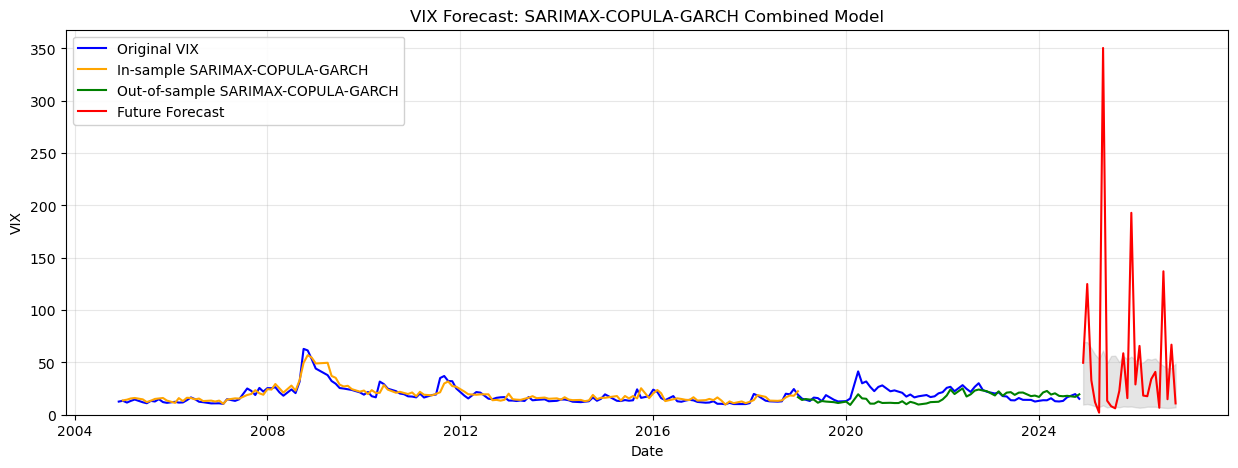

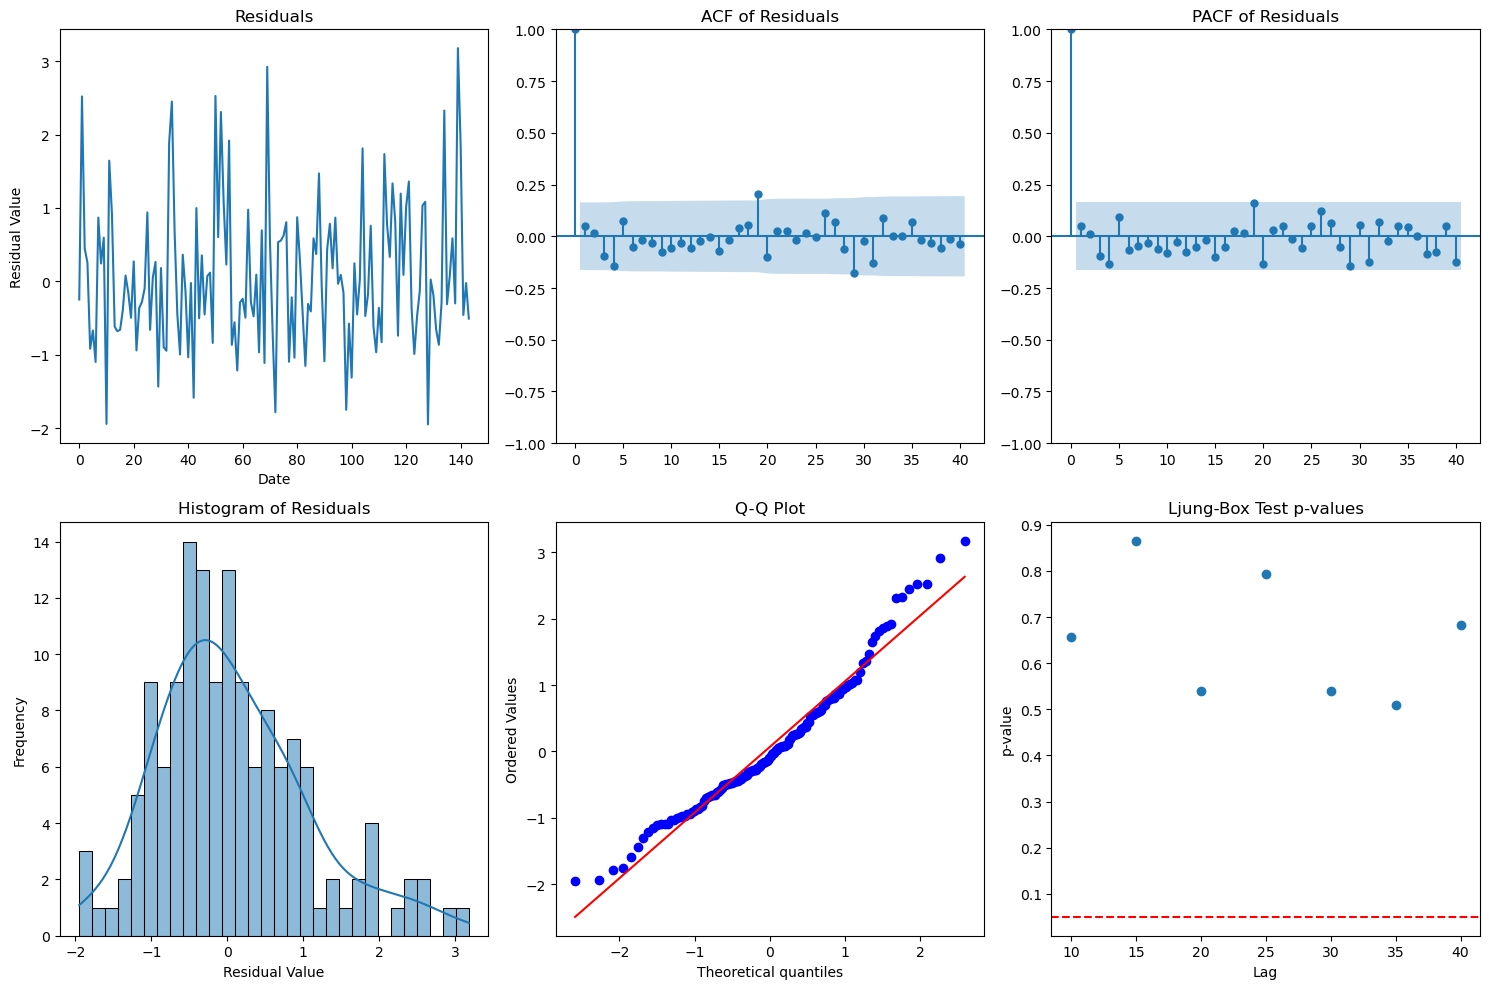


Jarque-Bera Test for Normality:
Statistic: 13.8421, p-value: 0.0010

Ljung-Box Test for Autocorrelation:
      lb_stat  lb_pvalue
10   7.722373   0.655934
15   9.224444   0.865492
20  18.724185   0.539814
25  19.062123   0.794132
30  28.567918   0.540369

Ljung-Box Test for ARCH effects:
      lb_stat  lb_pvalue
10   6.585288   0.763930
15   9.905678   0.825631
20  18.335862   0.565294
25  20.118947   0.740558
30  22.232819   0.845441

SARIMAX-GARCH R-squared: 0.6149
SARIMAX-GARCH RMSE: 5.0018
SARIMAX-GARCH MAPE: 0.1856
SARIMAX-GARCH Directional Accuracy: 0.6471


In [50]:
# GARCH model
garch_model_2 = arch_model(copula_residuals, vol='EGARCH', p=1, o=1, q=1, dist='studentsT', rescale=False)
garch_copula_results = garch_model_2.fit(disp='off', update_freq=5, options={'maxiter':10000})

# Generate volatility forecasts
in_sample_volatility = garch_copula_results.conditional_volatility
total_forecast_length = len(out_of_sample) + 24  # 24 months ahead
garch_forecast = garch_copula_results.forecast(horizon=total_forecast_length, method='simulation', reindex=False)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

df = garch_copula_results.params['nu']
rng = np.random.default_rng(42)

# Combine SARIMAX and GARCH
# In-sample combinations
in_sample_combined = (sarimax_in_sample_predictions[1:] + 
                      in_sample_volatility * rng.standard_t(df, size=len(sarimax_in_sample_predictions[1:])))

# Out-of-sample combinations
out_sample_combined = (sarimax_out_of_sample_predictions + 
                       forecast_volatility[:len(out_of_sample)] * rng.standard_t(df, size=len(out_of_sample)))

# Future forecast combinations
forecast_horizon = 24
future_forecast = sarimax_results.get_forecast(steps=forecast_horizon, exog=exog_out_of_sample.tail(24))
future_forecast_mean = future_forecast.predicted_mean
future_forecast_combined = np.exp(future_forecast_mean + 
                            forecast_volatility[len(out_of_sample):] * rng.standard_t(df, size=forecast_horizon))

# Ensure non-negative values
in_sample_combined = np.maximum(in_sample_combined, 0)
out_sample_combined = np.maximum(out_sample_combined, 0)
future_forecast_combined = np.maximum(future_forecast_combined, 0)

# Plot Results
plt.figure(figsize=(15, 5))
plt.plot(VIX.index, VIX, label='Original VIX', color='blue')
plt.plot(sarimax_in_sample_predictions.index[1:], in_sample_combined, 
         label='In-sample SARIMAX-COPULA-GARCH', color='orange')
plt.plot(sarimax_out_of_sample_predictions.index, out_sample_combined, 
         label='Out-of-sample SARIMAX-COPULA-GARCH', color='green')
plt.plot(forecast_dates, future_forecast_combined, 
         label='Future Forecast', color='red')

# Calculate 68% confidence intervals (approximately one standard deviation)
t_multiplier = stats.t.ppf(0.84, df)  # 68% CI using t-distribution
lower_bound = np.exp(future_forecast_mean - t_multiplier * forecast_volatility[len(out_of_sample):])
upper_bound = np.exp(future_forecast_mean + t_multiplier * forecast_volatility[len(out_of_sample):])

# Plot with 68% confidence intervals
plt.fill_between(forecast_dates, lower_bound, upper_bound,
                 color='gray', alpha=0.2)

plt.title('VIX Forecast: SARIMAX-COPULA-GARCH Combined Model')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)  # VIX cannot be negative
plt.legend(loc='best', framealpha=0.9)
plt.show()


# Calculate standardized residuals
standardized_residuals_2 = garch_copula_results.resid / garch_copula_results.conditional_volatility

# Create subplots for residual analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Residuals Time Series
axes[0, 0].plot(standardized_residuals_2)
axes[0, 0].set_title('Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual Value')

# Plot 2: ACF
plot_acf(standardized_residuals_2, ax=axes[0, 1], lags=40)
axes[0, 1].set_title('ACF of Residuals')

# Plot 3: PACF
plot_pacf(standardized_residuals_2, ax=axes[0, 2], lags=40)
axes[0, 2].set_title('PACF of Residuals')

# Plot 4: Histogram
sns.histplot(standardized_residuals_2, kde=True, ax=axes[1, 0], bins=30)
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].set_ylabel('Frequency')


# Plot 5: Q-Q Plot
stats.probplot(standardized_residuals_2, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# Plot 6: Ljung-Box Test
lb_results = acorr_ljungbox(standardized_residuals_2, lags=[10, 15, 20, 25, 30, 35, 40])
axes[1, 2].scatter(lb_results.index, lb_results['lb_pvalue'])
axes[1, 2].axhline(y=0.05, color='r', linestyle='--')
axes[1, 2].set_title('Ljung-Box Test p-values')
axes[1, 2].set_xlabel('Lag')
axes[1, 2].set_ylabel('p-value')

plt.tight_layout()
plt.show()

# Additional Statistical Tests
print("\nJarque-Bera Test for Normality:")
jb_test = stats.jarque_bera(standardized_residuals_2)
print(f"Statistic: {jb_test.statistic:.4f}, p-value: {jb_test.pvalue:.4f}")

print("\nLjung-Box Test for Autocorrelation:")
lb_test = acorr_ljungbox(standardized_residuals_2, lags=[10, 15, 20, 25, 30])
print(lb_test)

print("\nLjung-Box Test for ARCH effects:")
lb_test_squared = acorr_ljungbox(standardized_residuals_2**2, lags=[10, 15, 20, 25, 30])
print(lb_test_squared)

# Performance metrics
sarimax_copula_garch_combined_predictions = pd.concat([in_sample_combined, out_sample_combined])
sarimax_copula_garch_combined_predictions = sarimax_copula_garch_combined_predictions[~sarimax_copula_garch_combined_predictions.index.duplicated(keep='first')]

sarimax_copula_garch_r2 = r2_score(VIX[1:], sarimax_copula_garch_combined_predictions)
sarimax_copula_garch_rmse = root_mean_squared_error(VIX[1:], sarimax_copula_garch_combined_predictions)
sarimax_copula_garch_mape = mean_absolute_percentage_error(VIX[1:], sarimax_copula_garch_combined_predictions)
sarimax_copula_garch_da = mean_directional_accuracy(VIX[1:], sarimax_copula_garch_combined_predictions)


print(f"\nSARIMAX-GARCH R-squared: {sarimax_garch_r2:.4f}")
print(f"SARIMAX-GARCH RMSE: {sarimax_garch_rmse:.4f}")
print(f"SARIMAX-GARCH MAPE: {sarimax_garch_mape:.4f}")
print(f"SARIMAX-GARCH Directional Accuracy: {sarimax_garch_da:.4f}")

## Comparing Model metrics

This section compares the performance of different models using metrics such as R-squared, RMSE, MAPE, and Directional Accuracy. 

In [51]:
sarima_results.aic

818.4568988900103

In [52]:
sarimax_results.aic

-122.90666367199074

In [53]:
garch_results.aic

-160.30074743646568

In [54]:
garch_copula_results.aic

370.81395288525124


                      R-squared      RMSE      MAPE  Directional Accuracy
SARIMA                 0.530447  5.517501  0.192874              0.478049
SARIMAX                0.614305  5.005742  0.185741              0.632353
SARIMAX-GARCH          0.614907  5.001831  0.185552              0.647059
SARIMAX-COPULA-GARCH   0.594047  5.135519  0.195422              0.607843


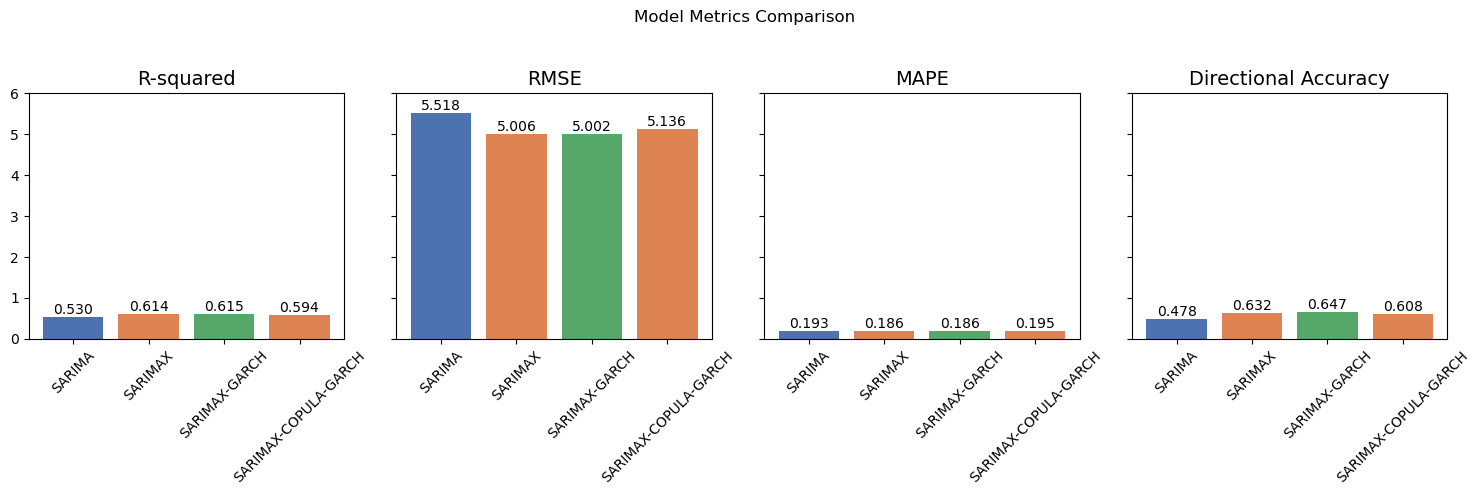

In [55]:
sarima_metrics = [sarima_r2, sarima_rmse, sarima_mape, sarima_da]
sarimax_metrics = [sarimax_r2, sarimax_rmse, sarimax_mape, sarimax_da]
sarimax_garch_metrics = [sarimax_garch_r2, sarimax_garch_rmse, sarimax_garch_mape, sarimax_garch_da]
sarimax_copula_garch_metrics = [sarimax_copula_garch_r2, sarimax_copula_garch_rmse, sarimax_copula_garch_mape, sarimax_copula_garch_da]


# Create a DataFrame to display the results
models = ['SARIMA', 'SARIMAX', 'SARIMAX-GARCH', 'SARIMAX-COPULA-GARCH']
metrics = ['R-squared', 'RMSE', 'MAPE', 'Directional Accuracy']

results = pd.DataFrame([sarima_metrics, sarimax_metrics, sarimax_garch_metrics, sarimax_copula_garch_metrics], 
                       columns=metrics, index=models)

print(f'\n{results}')

colors = ['#4c72b0', '#dd8452', '#55a868', '#dd8452']  # Blue, Orange, Green

# Plotting subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)  # Create 4 subplots in one row

for i, metric in enumerate(results.columns):
    ax = axes[i]
    bars = ax.bar(results.index, results[metric], color=colors)
    ax.set_title(metric, fontsize=14)  # Set subplot title
    ax.set_ylim(0, 6)  # Adjust y-axis limit for better visualization
    ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)  # Add actual value on top of each bar

# Add overall title and improve layout
fig.suptitle('Model Metrics Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit everything nicely
plt.show()


## VIX Forecast - 24 months into the future

The final forecast is generated using the best-performing model, providing a 24-month future prediction of the VIX index.

In [56]:
future_forecast_combined.describe()

count     24.000000
mean      55.483334
std       78.627353
min        1.976939
25%       13.037174
50%       25.820637
75%       60.464524
max      350.413912
Name: predicted_mean, dtype: float64